In [1]:
import matplotlib.pyplot as plt
# plt.rcParams['text.usetex'] = True

import xarray as xr
import pandas as pd
import os
import numpy as np
import pickle as pkl

import ML_models.base_model as base_model
from ML_models.SARIMA_model import SARIMA_model
from ML_models.SARIMAX_model import SARIMAX_model
from ML_models.monthly_model import monthly_model
from ML_models.prior_model import prior_model

In [2]:
with xr.open_dataset('./vars_per_eco_update.nc') as ds:
    # print(ds)
    var_ds = ds

print(var_ds.data_vars)

with xr.open_dataset('./fitted_sf/prior_sf.nc') as ds:
    prior_sf = ds

prior_sf.where(prior_sf['testing_time'].isnull(), drop=True)

Data variables:
    regions           (lat, lon) float32 ...
    grid_cell_weight  (lat, lon) float64 ...
    grid_cell_area    (lat, lon) float32 ...
    TER               (lat, lon) float64 ...
    monthly_flux      (eco_regions, time) float64 ...
    smoothed_flux     (eco_regions, time) float64 ...
    opt_flux          (eco_regions, time) float32 ...
    prior_flux_per_s  (eco_regions, time) float32 ...
    scaling_factor    (eco_regions, time) float32 ...
    sf_per_eco        (eco_regions, time) float32 ...
    monthly_sf        (eco_regions, time) float64 ...
    smoothed_sf       (eco_regions, time) float64 ...
    g10m_MAX          (eco_regions, time) float64 ...
    swvl1_MIN         (eco_regions, time) float64 ...
    swvl1_MAX         (eco_regions, time) float64 ...
    slhf_MIN          (eco_regions, time) float64 ...
    slhf_MAX          (eco_regions, time) float64 ...
    slhf_AVG          (eco_regions, time) float64 ...
    sshf_MIN          (eco_regions, time) float6

<xarray.Dataset>
Dimensions:           (time: 888, eco_regions: 68, n_train_years: 17)
Coordinates:
  * time              (time) datetime64[ns] 2000-01-01 2000-01-08 ... 2016-12-31
  * eco_regions       (eco_regions) float64 1.0 3.0 4.0 ... 204.0 206.0 209.0
  * n_train_years     (n_train_years) int32 1 2 3 4 5 6 7 ... 12 13 14 15 16 17
Data variables:
    testing_time      (time) datetime64[ns] NaT NaT NaT NaT ... NaT NaT NaT NaT
    prior_flux_per_s  (eco_regions, time) float32 1.726e+06 ... 9.057e+04
    sf_per_eco        (eco_regions, time) float32 0.2209 0.7194 ... 1.277 0.7495
    optimized_flux    (eco_regions, time) float32 3.813e+05 ... 6.788e+04
    predicted_sf      (eco_regions, n_train_years, time) float64 nan nan ... 1.0
    predicted_flux    (eco_regions, n_train_years, time) float64 nan ... 9.05...
    eco_area          (eco_regions, time) float32 2.315e+12 ... 1.485e+12
    tc_region         (eco_regions, time) float64 1.0 1.0 1.0 ... 11.0 11.0 11.0
    training_time     (n_train_years, time) datetime64[ns] NaT ... 2016-12-31
Attributes:
    Description:  Total prior flux for each eco-region
    Units:        mol s^-1

In [3]:
  prior_sf.eco_regions.values

array([  1.,   3.,   4.,   7.,   8.,   9.,  10.,  11.,  15.,  16.,  19.,
        20.,  21.,  22.,  23.,  24.,  25.,  26.,  27.,  29.,  30.,  31.,
        32.,  33.,  34.,  35.,  38., 115., 116., 117., 118., 121., 122.,
       123., 124., 125., 128., 130., 133., 134., 135., 136., 137., 138.,
       139., 140., 141., 143., 144., 145., 146., 147., 152., 191., 192.,
       193., 194., 195., 196., 197., 198., 199., 200., 201., 202., 204.,
       206., 209.])

In [22]:
fac= 86400.*365.*12./1e15 # from mol/region/s to PgC/yr


with xr.open_dataset('./fitted_sf/prior_sf.nc') as ds:
    prior_sf = ds
print(prior_sf.predicted_flux.loc[dict(n_train_years=10, eco_regions=slice(1.0, 19.0))].where(prior_sf.testing_time.notnull(), drop=True)*fac)

print(prior_sf.optimized_flux.loc[dict(eco_regions=slice(1.0, 19.0))].where(prior_sf.testing_time.notnull(), drop=True)*fac)

<xarray.DataArray 'predicted_flux' (eco_regions: 11, time: 208)>
array([[0.65020441, 0.6482446 , 0.64225554, ..., 0.65745654, 0.6550156 ,
        0.6533698 ],
       [0.15826485, 0.16063484, 0.1608118 , ..., 0.16117687, 0.16504231,
        0.16096274],
       [0.0107523 , 0.01011662, 0.01013321, ..., 0.0116244 , 0.01136772,
        0.01142082],
       ...,
       [0.01195937, 0.01203893, 0.01239861, ..., 0.0113811 , 0.01109883,
        0.01116875],
       [0.05690065, 0.05682922, 0.05706667, ..., 0.06049357, 0.06008461,
        0.06015557],
       [0.12982083, 0.12759709, 0.13002689, ..., 0.12160627, 0.12373758,
        0.1221817 ]])
Coordinates:
  * time           (time) datetime64[ns] 2017-01-07 2017-01-14 ... 2020-12-26
  * eco_regions    (eco_regions) float64 1.0 3.0 4.0 7.0 ... 11.0 15.0 16.0 19.0
    n_train_years  int32 10
<xarray.DataArray 'optimized_flux' (eco_regions: 11, time: 208)>
array([[ 0.15996921,  0.5687218 ,  0.5913692 , ...,  0.55272055,
         0.33486637,  0.1610

In [ ]:
import timeit

start_time = timeit.default_timer()


prior_m = prior_model(machine='local', show_fit=True)
sf_ds = prior_m.run_model(data_file='vars_per_eco_update.nc')

print(sf_ds)
# sf_file = monthly_model.SF_DIR + 'monthly_sf.nc'
#
# with xr.open_dataset(sf_file) as ds:
#     sf_ds = ds

# tc_results = prior_m.test_model(sf_ds, per_tc_region=True)
# print(tc_results)

# tc_results_file = prior_m.RESULTS_DIR + 'prior_results_per_tc.pkl'
# tc_results.to_pickle(tc_results_file)

# res_df = prior_m.test_model(sf_ds)
# results_file = prior_m.RESULTS_DIR + 'prior_results.pkl'
# print(res_df)
# res_df.to_pickle(results_file)


stop_time = timeit.default_timer()

print(f'Elapsed time: {stop_time-start_time}')


Determining sf prediction of region 1.0
No sf data exists on region 1.0. Making new sf prediction
Determining sf prediction of region 7.0
did not find a match in any of xarray's currently installed IO backends ['h5netcdf', 'scipy']. Consider explicitly selecting one of the installed engines via the ``engine`` parameter, or installing additional IO dependencies, see:
https://docs.xarray.dev/en/stable/getting-started-guide/installing.html
https://docs.xarray.dev/en/stable/user-guide/io.htmlNo sf data exists on region 7.0. Making new sf prediction

The loaded file contained an incompatible model. Training a new model
starting training process of monthly model, at eco-region 1.0 using data starting at 2000
Determining sf prediction of region 10.0
No sf data exists on region 10.0. Making new sf prediction
did not find a match in any of xarray's currently installed IO backends ['h5netcdf', 'scipy']. Consider explicitly selecting one of the installed engines via the ``engine`` parameter, or i

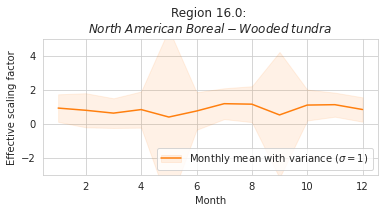

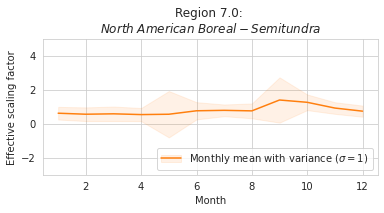

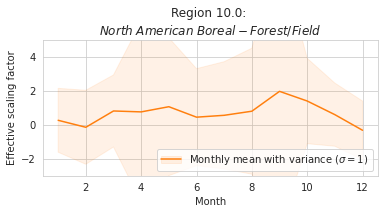

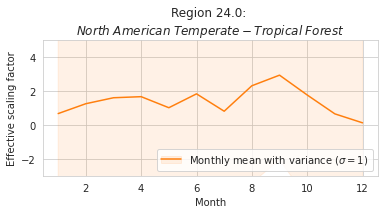

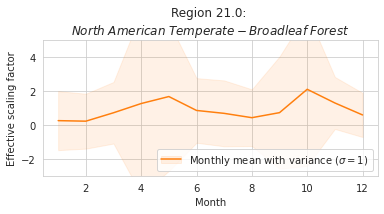

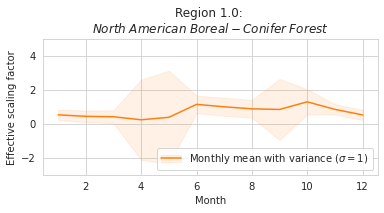

did not find a match in any of xarray's currently installed IO backends ['h5netcdf', 'scipy']. Consider explicitly selecting one of the installed engines via the ``engine`` parameter, or installing additional IO dependencies, see:
https://docs.xarray.dev/en/stable/getting-started-guide/installing.html
https://docs.xarray.dev/en/stable/user-guide/io.html
The loaded file contained an incompatible model. Training a new model
starting training process of monthly model, at eco-region 7.0 using data starting at 2001
did not find a match in any of xarray's currently installed IO backends ['h5netcdf', 'scipy']. Consider explicitly selecting one of the installed engines via the ``engine`` parameter, or installing additional IO dependencies, see:
https://docs.xarray.dev/en/stable/getting-started-guide/installing.html
https://docs.xarray.dev/en/stable/user-guide/io.html
The loaded file contained an incompatible model. Training a new model
starting training process of monthly model, at eco-region 

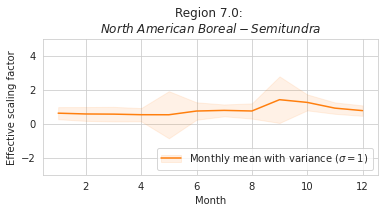

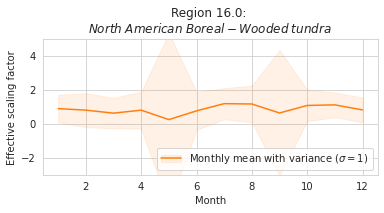

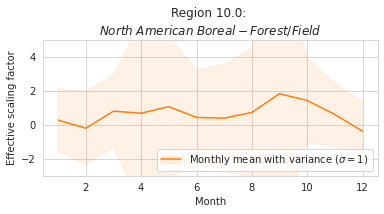

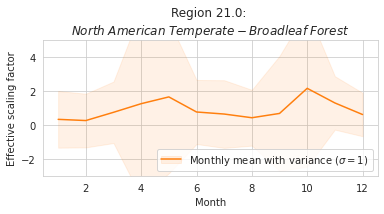

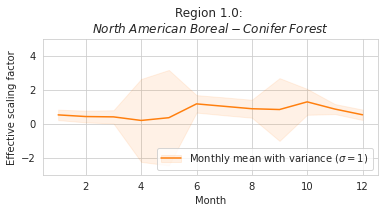

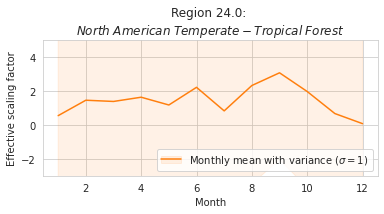

did not find a match in any of xarray's currently installed IO backends ['h5netcdf', 'scipy']. Consider explicitly selecting one of the installed engines via the ``engine`` parameter, or installing additional IO dependencies, see:
https://docs.xarray.dev/en/stable/getting-started-guide/installing.html
https://docs.xarray.dev/en/stable/user-guide/io.html
The loaded file contained an incompatible model. Training a new model
starting training process of monthly model, at eco-region 7.0 using data starting at 2002
did not find a match in any of xarray's currently installed IO backends ['h5netcdf', 'scipy']. Consider explicitly selecting one of the installed engines via the ``engine`` parameter, or installing additional IO dependencies, see:
https://docs.xarray.dev/en/stable/getting-started-guide/installing.html
https://docs.xarray.dev/en/stable/user-guide/io.html
The loaded file contained an incompatible model. Training a new model
starting training process of monthly model, at eco-region 

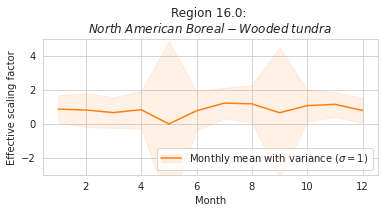

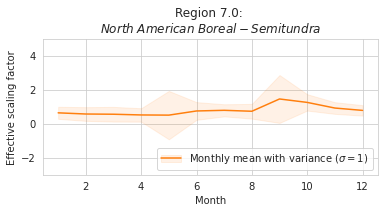

did not find a match in any of xarray's currently installed IO backends ['h5netcdf', 'scipy']. Consider explicitly selecting one of the installed engines via the ``engine`` parameter, or installing additional IO dependencies, see:
https://docs.xarray.dev/en/stable/getting-started-guide/installing.html
https://docs.xarray.dev/en/stable/user-guide/io.html
The loaded file contained an incompatible model. Training a new model
starting training process of monthly model, at eco-region 16.0 using data starting at 2003


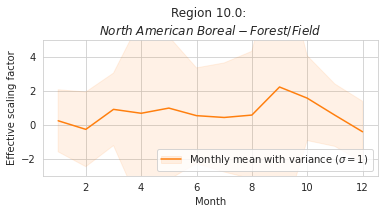

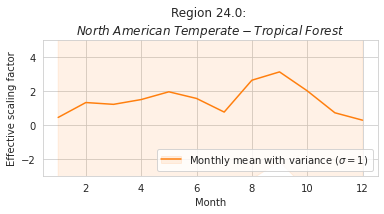

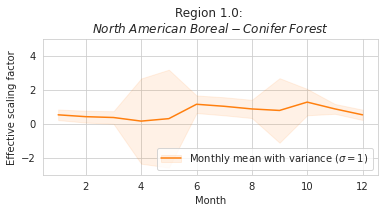

did not find a match in any of xarray's currently installed IO backends ['h5netcdf', 'scipy']. Consider explicitly selecting one of the installed engines via the ``engine`` parameter, or installing additional IO dependencies, see:
https://docs.xarray.dev/en/stable/getting-started-guide/installing.html
https://docs.xarray.dev/en/stable/user-guide/io.html
The loaded file contained an incompatible model. Training a new model
starting training process of monthly model, at eco-region 7.0 using data starting at 2003


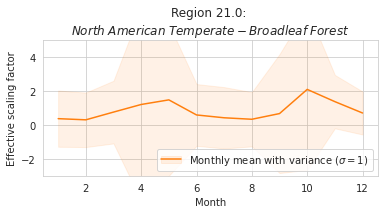

did not find a match in any of xarray's currently installed IO backends ['h5netcdf', 'scipy']. Consider explicitly selecting one of the installed engines via the ``engine`` parameter, or installing additional IO dependencies, see:
https://docs.xarray.dev/en/stable/getting-started-guide/installing.html
https://docs.xarray.dev/en/stable/user-guide/io.html
The loaded file contained an incompatible model. Training a new model
starting training process of monthly model, at eco-region 10.0 using data starting at 2003
did not find a match in any of xarray's currently installed IO backends ['h5netcdf', 'scipy']. Consider explicitly selecting one of the installed engines via the ``engine`` parameter, or installing additional IO dependencies, see:
https://docs.xarray.dev/en/stable/getting-started-guide/installing.html
https://docs.xarray.dev/en/stable/user-guide/io.html
The loaded file contained an incompatible model. Training a new model
starting training process of monthly model, at eco-region

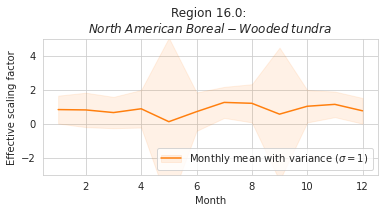

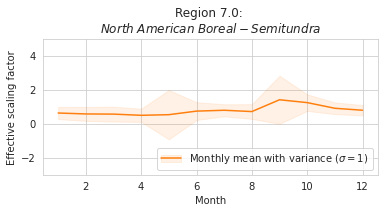

did not find a match in any of xarray's currently installed IO backends ['h5netcdf', 'scipy']. Consider explicitly selecting one of the installed engines via the ``engine`` parameter, or installing additional IO dependencies, see:
https://docs.xarray.dev/en/stable/getting-started-guide/installing.html
https://docs.xarray.dev/en/stable/user-guide/io.html
The loaded file contained an incompatible model. Training a new model
starting training process of monthly model, at eco-region 16.0 using data starting at 2004
did not find a match in any of xarray's currently installed IO backends ['h5netcdf', 'scipy']. Consider explicitly selecting one of the installed engines via the ``engine`` parameter, or installing additional IO dependencies, see:
https://docs.xarray.dev/en/stable/getting-started-guide/installing.html
https://docs.xarray.dev/en/stable/user-guide/io.html
The loaded file contained an incompatible model. Training a new model
starting training process of monthly model, at eco-region

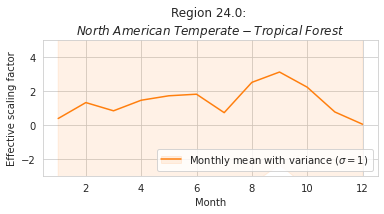

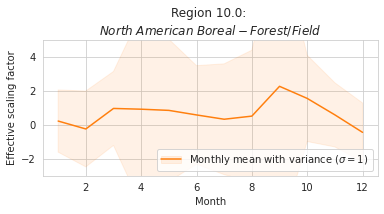

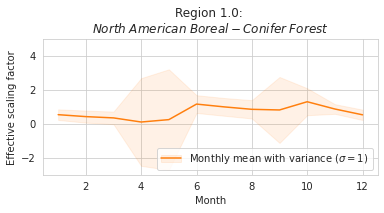

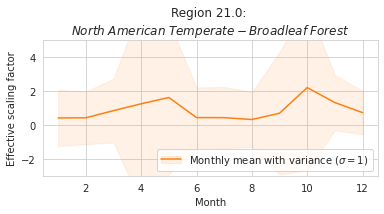

did not find a match in any of xarray's currently installed IO backends ['h5netcdf', 'scipy']. Consider explicitly selecting one of the installed engines via the ``engine`` parameter, or installing additional IO dependencies, see:
https://docs.xarray.dev/en/stable/getting-started-guide/installing.html
https://docs.xarray.dev/en/stable/user-guide/io.html
The loaded file contained an incompatible model. Training a new model
starting training process of monthly model, at eco-region 24.0 using data starting at 2004
did not find a match in any of xarray's currently installed IO backends ['h5netcdf', 'scipy']. Consider explicitly selecting one of the installed engines via the ``engine`` parameter, or installing additional IO dependencies, see:
https://docs.xarray.dev/en/stable/getting-started-guide/installing.html
https://docs.xarray.dev/en/stable/user-guide/io.html
The loaded file contained an incompatible model. Training a new model
starting training process of monthly model, at eco-region

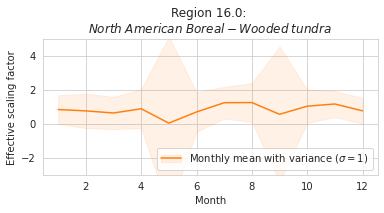

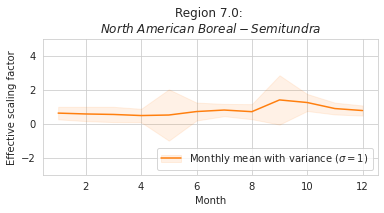

did not find a match in any of xarray's currently installed IO backends ['h5netcdf', 'scipy']. Consider explicitly selecting one of the installed engines via the ``engine`` parameter, or installing additional IO dependencies, see:
https://docs.xarray.dev/en/stable/getting-started-guide/installing.html
https://docs.xarray.dev/en/stable/user-guide/io.html
The loaded file contained an incompatible model. Training a new model
starting training process of monthly model, at eco-region 16.0 using data starting at 2005
did not find a match in any of xarray's currently installed IO backends ['h5netcdf', 'scipy']. Consider explicitly selecting one of the installed engines via the ``engine`` parameter, or installing additional IO dependencies, see:
https://docs.xarray.dev/en/stable/getting-started-guide/installing.html
https://docs.xarray.dev/en/stable/user-guide/io.html
The loaded file contained an incompatible model. Training a new model
starting training process of monthly model, at eco-region

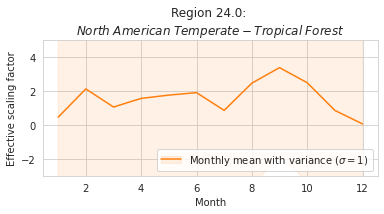

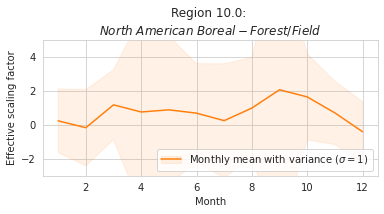

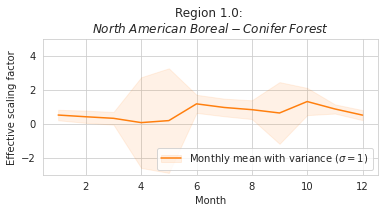

did not find a match in any of xarray's currently installed IO backends ['h5netcdf', 'scipy']. Consider explicitly selecting one of the installed engines via the ``engine`` parameter, or installing additional IO dependencies, see:
https://docs.xarray.dev/en/stable/getting-started-guide/installing.html
https://docs.xarray.dev/en/stable/user-guide/io.html
The loaded file contained an incompatible model. Training a new model
starting training process of monthly model, at eco-region 24.0 using data starting at 2005


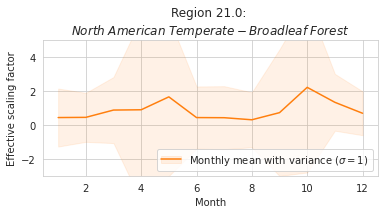

did not find a match in any of xarray's currently installed IO backends ['h5netcdf', 'scipy']. Consider explicitly selecting one of the installed engines via the ``engine`` parameter, or installing additional IO dependencies, see:
https://docs.xarray.dev/en/stable/getting-started-guide/installing.html
https://docs.xarray.dev/en/stable/user-guide/io.html
The loaded file contained an incompatible model. Training a new model
starting training process of monthly model, at eco-region 10.0 using data starting at 2005
did not find a match in any of xarray's currently installed IO backends ['h5netcdf', 'scipy']. Consider explicitly selecting one of the installed engines via the ``engine`` parameter, or installing additional IO dependencies, see:
https://docs.xarray.dev/en/stable/getting-started-guide/installing.html
https://docs.xarray.dev/en/stable/user-guide/io.html
The loaded file contained an incompatible model. Training a new model
starting training process of monthly model, at eco-region

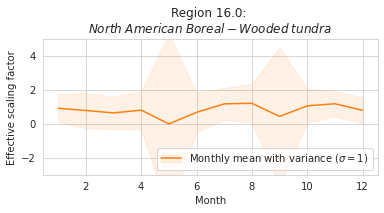

did not find a match in any of xarray's currently installed IO backends ['h5netcdf', 'scipy']. Consider explicitly selecting one of the installed engines via the ``engine`` parameter, or installing additional IO dependencies, see:
https://docs.xarray.dev/en/stable/getting-started-guide/installing.html
https://docs.xarray.dev/en/stable/user-guide/io.html
The loaded file contained an incompatible model. Training a new model
starting training process of monthly model, at eco-region 21.0 using data starting at 2005


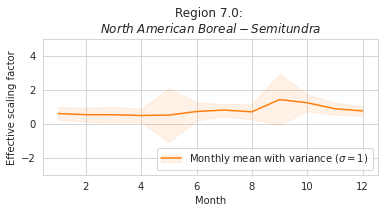

did not find a match in any of xarray's currently installed IO backends ['h5netcdf', 'scipy']. Consider explicitly selecting one of the installed engines via the ``engine`` parameter, or installing additional IO dependencies, see:
https://docs.xarray.dev/en/stable/getting-started-guide/installing.html
https://docs.xarray.dev/en/stable/user-guide/io.html
The loaded file contained an incompatible model. Training a new model
starting training process of monthly model, at eco-region 16.0 using data starting at 2006
did not find a match in any of xarray's currently installed IO backends ['h5netcdf', 'scipy']. Consider explicitly selecting one of the installed engines via the ``engine`` parameter, or installing additional IO dependencies, see:
https://docs.xarray.dev/en/stable/getting-started-guide/installing.html
https://docs.xarray.dev/en/stable/user-guide/io.html
The loaded file contained an incompatible model. Training a new model
starting training process of monthly model, at eco-region

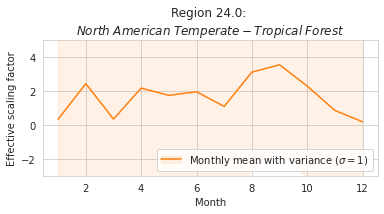

did not find a match in any of xarray's currently installed IO backends ['h5netcdf', 'scipy']. Consider explicitly selecting one of the installed engines via the ``engine`` parameter, or installing additional IO dependencies, see:
https://docs.xarray.dev/en/stable/getting-started-guide/installing.html
https://docs.xarray.dev/en/stable/user-guide/io.html
The loaded file contained an incompatible model. Training a new model
starting training process of monthly model, at eco-region 24.0 using data starting at 2006


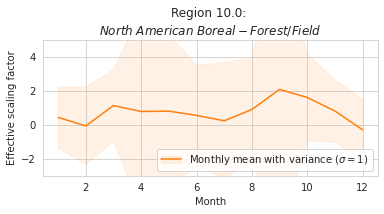

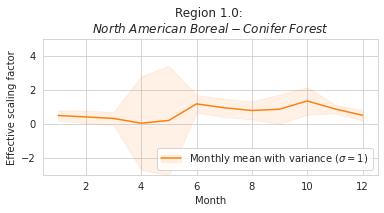

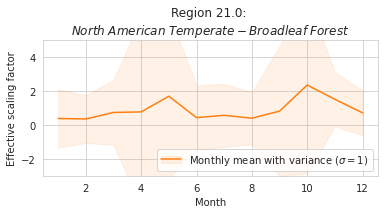

did not find a match in any of xarray's currently installed IO backends ['h5netcdf', 'scipy']. Consider explicitly selecting one of the installed engines via the ``engine`` parameter, or installing additional IO dependencies, see:
https://docs.xarray.dev/en/stable/getting-started-guide/installing.html
https://docs.xarray.dev/en/stable/user-guide/io.html
The loaded file contained an incompatible model. Training a new model
starting training process of monthly model, at eco-region 10.0 using data starting at 2006
did not find a match in any of xarray's currently installed IO backends ['h5netcdf', 'scipy']. Consider explicitly selecting one of the installed engines via the ``engine`` parameter, or installing additional IO dependencies, see:
https://docs.xarray.dev/en/stable/getting-started-guide/installing.html
https://docs.xarray.dev/en/stable/user-guide/io.html
The loaded file contained an incompatible model. Training a new model
starting training process of monthly model, at eco-region

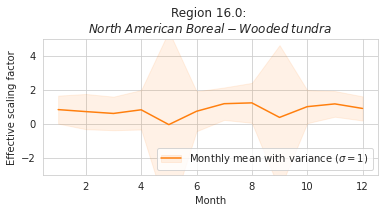

did not find a match in any of xarray's currently installed IO backends ['h5netcdf', 'scipy']. Consider explicitly selecting one of the installed engines via the ``engine`` parameter, or installing additional IO dependencies, see:
https://docs.xarray.dev/en/stable/getting-started-guide/installing.html
https://docs.xarray.dev/en/stable/user-guide/io.html
The loaded file contained an incompatible model. Training a new model
starting training process of monthly model, at eco-region 21.0 using data starting at 2006


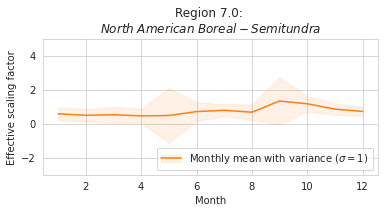

did not find a match in any of xarray's currently installed IO backends ['h5netcdf', 'scipy']. Consider explicitly selecting one of the installed engines via the ``engine`` parameter, or installing additional IO dependencies, see:
https://docs.xarray.dev/en/stable/getting-started-guide/installing.html
https://docs.xarray.dev/en/stable/user-guide/io.html
The loaded file contained an incompatible model. Training a new model
starting training process of monthly model, at eco-region 16.0 using data starting at 2007
did not find a match in any of xarray's currently installed IO backends ['h5netcdf', 'scipy']. Consider explicitly selecting one of the installed engines via the ``engine`` parameter, or installing additional IO dependencies, see:
https://docs.xarray.dev/en/stable/getting-started-guide/installing.html
https://docs.xarray.dev/en/stable/user-guide/io.html
The loaded file contained an incompatible model. Training a new model
starting training process of monthly model, at eco-region

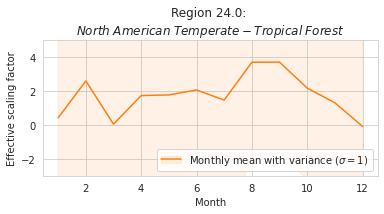

did not find a match in any of xarray's currently installed IO backends ['h5netcdf', 'scipy']. Consider explicitly selecting one of the installed engines via the ``engine`` parameter, or installing additional IO dependencies, see:
https://docs.xarray.dev/en/stable/getting-started-guide/installing.html
https://docs.xarray.dev/en/stable/user-guide/io.html
The loaded file contained an incompatible model. Training a new model
starting training process of monthly model, at eco-region 24.0 using data starting at 2007


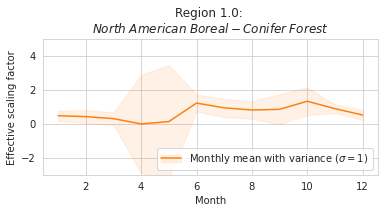

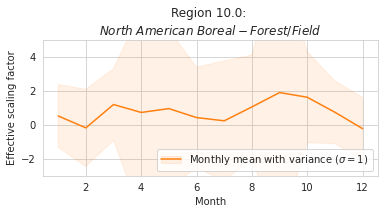

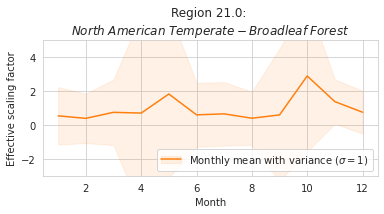

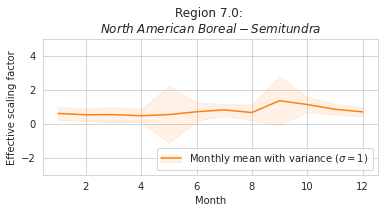

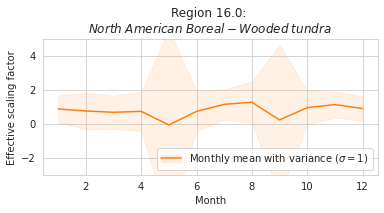

did not find a match in any of xarray's currently installed IO backends ['h5netcdf', 'scipy']. Consider explicitly selecting one of the installed engines via the ``engine`` parameter, or installing additional IO dependencies, see:
https://docs.xarray.dev/en/stable/getting-started-guide/installing.html
https://docs.xarray.dev/en/stable/user-guide/io.html
The loaded file contained an incompatible model. Training a new model
starting training process of monthly model, at eco-region 1.0 using data starting at 2007
did not find a match in any of xarray's currently installed IO backends ['h5netcdf', 'scipy']. Consider explicitly selecting one of the installed engines via the ``engine`` parameter, or installing additional IO dependencies, see:
https://docs.xarray.dev/en/stable/getting-started-guide/installing.html
https://docs.xarray.dev/en/stable/user-guide/io.html
The loaded file contained an incompatible model. Training a new model
starting training process of monthly model, at eco-region 

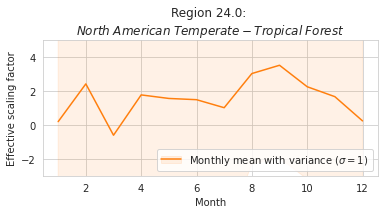

did not find a match in any of xarray's currently installed IO backends ['h5netcdf', 'scipy']. Consider explicitly selecting one of the installed engines via the ``engine`` parameter, or installing additional IO dependencies, see:
https://docs.xarray.dev/en/stable/getting-started-guide/installing.html
https://docs.xarray.dev/en/stable/user-guide/io.html
The loaded file contained an incompatible model. Training a new model
starting training process of monthly model, at eco-region 24.0 using data starting at 2008


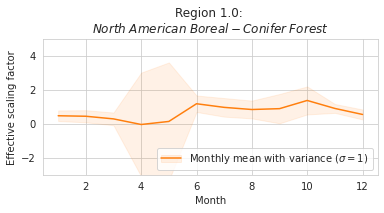

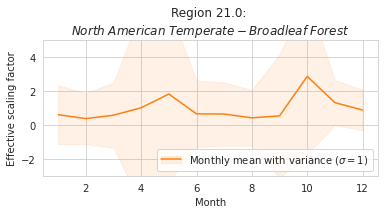

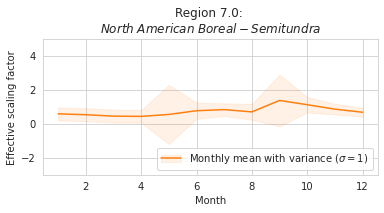

did not find a match in any of xarray's currently installed IO backends ['h5netcdf', 'scipy']. Consider explicitly selecting one of the installed engines via the ``engine`` parameter, or installing additional IO dependencies, see:
https://docs.xarray.dev/en/stable/getting-started-guide/installing.html
https://docs.xarray.dev/en/stable/user-guide/io.html
The loaded file contained an incompatible model. Training a new model
starting training process of monthly model, at eco-region 1.0 using data starting at 2008


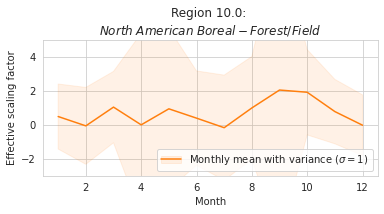

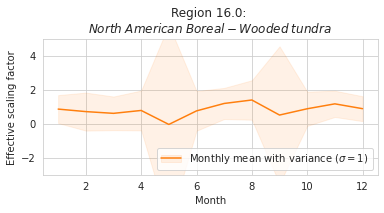

did not find a match in any of xarray's currently installed IO backends ['h5netcdf', 'scipy']. Consider explicitly selecting one of the installed engines via the ``engine`` parameter, or installing additional IO dependencies, see:
https://docs.xarray.dev/en/stable/getting-started-guide/installing.html
https://docs.xarray.dev/en/stable/user-guide/io.html
The loaded file contained an incompatible model. Training a new model
starting training process of monthly model, at eco-region 7.0 using data starting at 2009
did not find a match in any of xarray's currently installed IO backends ['h5netcdf', 'scipy']. Consider explicitly selecting one of the installed engines via the ``engine`` parameter, or installing additional IO dependencies, see:
https://docs.xarray.dev/en/stable/getting-started-guide/installing.html
https://docs.xarray.dev/en/stable/user-guide/io.html
The loaded file contained an incompatible model. Training a new model
starting training process of monthly model, at eco-region 

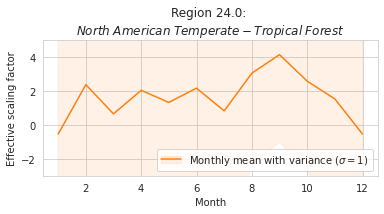


starting training process of monthly model, at eco-region 10.0 using data starting at 2008
did not find a match in any of xarray's currently installed IO backends ['h5netcdf', 'scipy']. Consider explicitly selecting one of the installed engines via the ``engine`` parameter, or installing additional IO dependencies, see:
https://docs.xarray.dev/en/stable/getting-started-guide/installing.html
https://docs.xarray.dev/en/stable/user-guide/io.html
The loaded file contained an incompatible model. Training a new model
starting training process of monthly model, at eco-region 16.0 using data starting at 2009
did not find a match in any of xarray's currently installed IO backends ['h5netcdf', 'scipy']. Consider explicitly selecting one of the installed engines via the ``engine`` parameter, or installing additional IO dependencies, see:
https://docs.xarray.dev/en/stable/getting-started-guide/installing.html
https://docs.xarray.dev/en/stable/user-guide/io.html
The loaded file contained an incomp

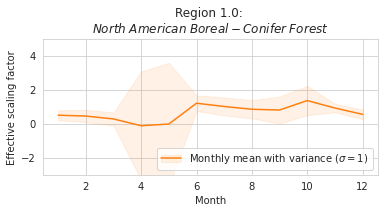

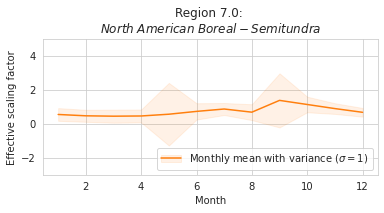

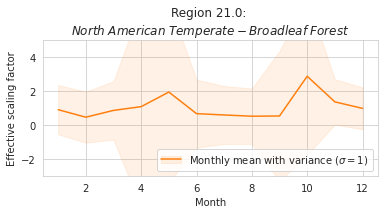

did not find a match in any of xarray's currently installed IO backends ['h5netcdf', 'scipy']. Consider explicitly selecting one of the installed engines via the ``engine`` parameter, or installing additional IO dependencies, see:
https://docs.xarray.dev/en/stable/getting-started-guide/installing.html
https://docs.xarray.dev/en/stable/user-guide/io.html
The loaded file contained an incompatible model. Training a new model
starting training process of monthly model, at eco-region 1.0 using data starting at 2009


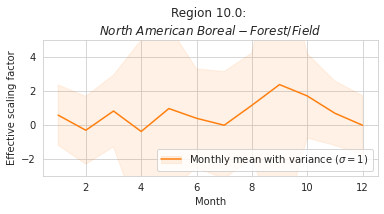

did not find a match in any of xarray's currently installed IO backends ['h5netcdf', 'scipy']. Consider explicitly selecting one of the installed engines via the ``engine`` parameter, or installing additional IO dependencies, see:
https://docs.xarray.dev/en/stable/getting-started-guide/installing.html
https://docs.xarray.dev/en/stable/user-guide/io.html
The loaded file contained an incompatible model. Training a new model
starting training process of monthly model, at eco-region 7.0 using data starting at 2010


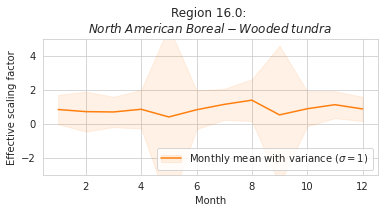

did not find a match in any of xarray's currently installed IO backends ['h5netcdf', 'scipy']. Consider explicitly selecting one of the installed engines via the ``engine`` parameter, or installing additional IO dependencies, see:
https://docs.xarray.dev/en/stable/getting-started-guide/installing.html
https://docs.xarray.dev/en/stable/user-guide/io.html
The loaded file contained an incompatible model. Training a new model
starting training process of monthly model, at eco-region 21.0 using data starting at 2009


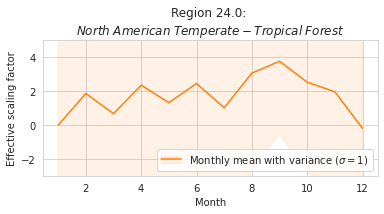

did not find a match in any of xarray's currently installed IO backends ['h5netcdf', 'scipy']. Consider explicitly selecting one of the installed engines via the ``engine`` parameter, or installing additional IO dependencies, see:
https://docs.xarray.dev/en/stable/getting-started-guide/installing.html
https://docs.xarray.dev/en/stable/user-guide/io.html
The loaded file contained an incompatible model. Training a new model
starting training process of monthly model, at eco-region 10.0 using data starting at 2009
did not find a match in any of xarray's currently installed IO backends ['h5netcdf', 'scipy']. Consider explicitly selecting one of the installed engines via the ``engine`` parameter, or installing additional IO dependencies, see:
https://docs.xarray.dev/en/stable/getting-started-guide/installing.html
https://docs.xarray.dev/en/stable/user-guide/io.html
The loaded file contained an incompatible model. Training a new model
starting training process of monthly model, at eco-region

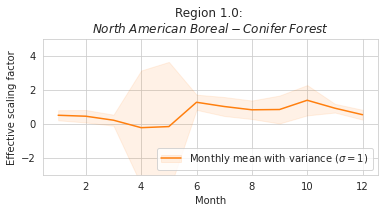

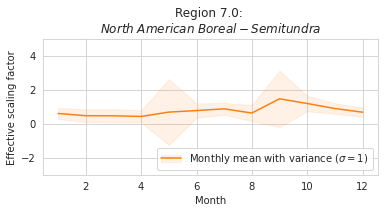

did not find a match in any of xarray's currently installed IO backends ['h5netcdf', 'scipy']. Consider explicitly selecting one of the installed engines via the ``engine`` parameter, or installing additional IO dependencies, see:
https://docs.xarray.dev/en/stable/getting-started-guide/installing.html
https://docs.xarray.dev/en/stable/user-guide/io.html
The loaded file contained an incompatible model. Training a new model
starting training process of monthly model, at eco-region 1.0 using data starting at 2010
did not find a match in any of xarray's currently installed IO backends ['h5netcdf', 'scipy']. Consider explicitly selecting one of the installed engines via the ``engine`` parameter, or installing additional IO dependencies, see:
https://docs.xarray.dev/en/stable/getting-started-guide/installing.html
https://docs.xarray.dev/en/stable/user-guide/io.html
The loaded file contained an incompatible model. Training a new model
starting training process of monthly model, at eco-region 

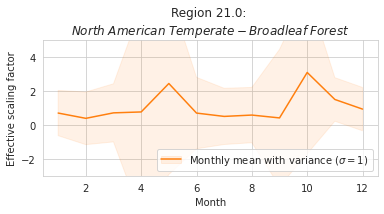

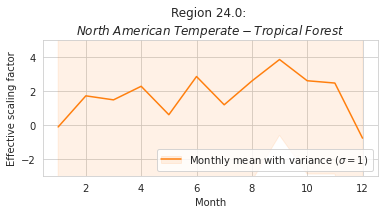

did not find a match in any of xarray's currently installed IO backends ['h5netcdf', 'scipy']. Consider explicitly selecting one of the installed engines via the ``engine`` parameter, or installing additional IO dependencies, see:
https://docs.xarray.dev/en/stable/getting-started-guide/installing.html
https://docs.xarray.dev/en/stable/user-guide/io.html
The loaded file contained an incompatible model. Training a new model
starting training process of monthly model, at eco-region 21.0 using data starting at 2010


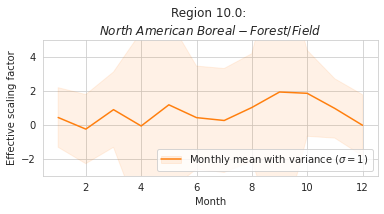

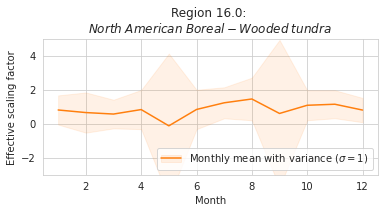

did not find a match in any of xarray's currently installed IO backends ['h5netcdf', 'scipy']. Consider explicitly selecting one of the installed engines via the ``engine`` parameter, or installing additional IO dependencies, see:
https://docs.xarray.dev/en/stable/getting-started-guide/installing.html
https://docs.xarray.dev/en/stable/user-guide/io.html
The loaded file contained an incompatible model. Training a new model
starting training process of monthly model, at eco-region 24.0 using data starting at 2011
did not find a match in any of xarray's currently installed IO backends ['h5netcdf', 'scipy']. Consider explicitly selecting one of the installed engines via the ``engine`` parameter, or installing additional IO dependencies, see:
https://docs.xarray.dev/en/stable/getting-started-guide/installing.html
https://docs.xarray.dev/en/stable/user-guide/io.html
The loaded file contained an incompatible model. Training a new model
starting training process of monthly model, at eco-region

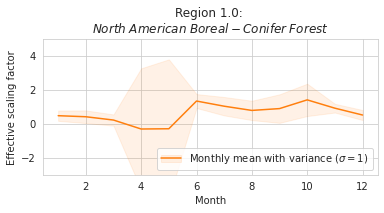

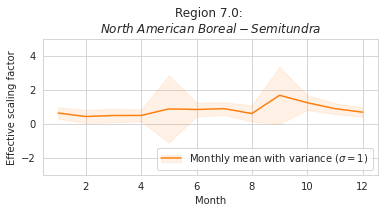

did not find a match in any of xarray's currently installed IO backends ['h5netcdf', 'scipy']. Consider explicitly selecting one of the installed engines via the ``engine`` parameter, or installing additional IO dependencies, see:
https://docs.xarray.dev/en/stable/getting-started-guide/installing.html
https://docs.xarray.dev/en/stable/user-guide/io.html
The loaded file contained an incompatible model. Training a new model
starting training process of monthly model, at eco-region 16.0 using data starting at 2011
did not find a match in any of xarray's currently installed IO backends ['h5netcdf', 'scipy']. Consider explicitly selecting one of the installed engines via the ``engine`` parameter, or installing additional IO dependencies, see:
https://docs.xarray.dev/en/stable/getting-started-guide/installing.html
https://docs.xarray.dev/en/stable/user-guide/io.html
The loaded file contained an incompatible model. Training a new model
starting training process of monthly model, at eco-region

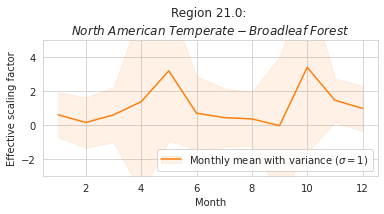

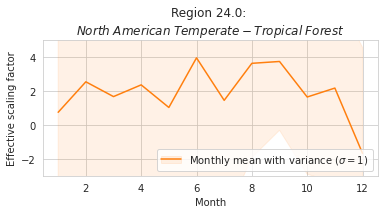

did not find a match in any of xarray's currently installed IO backends ['h5netcdf', 'scipy']. Consider explicitly selecting one of the installed engines via the ``engine`` parameter, or installing additional IO dependencies, see:
https://docs.xarray.dev/en/stable/getting-started-guide/installing.html
https://docs.xarray.dev/en/stable/user-guide/io.html
The loaded file contained an incompatible model. Training a new model
starting training process of monthly model, at eco-region 21.0 using data starting at 2011


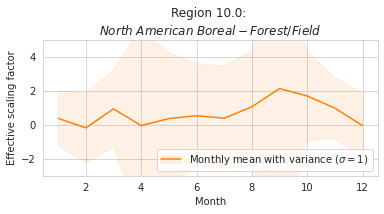

did not find a match in any of xarray's currently installed IO backends ['h5netcdf', 'scipy']. Consider explicitly selecting one of the installed engines via the ``engine`` parameter, or installing additional IO dependencies, see:
https://docs.xarray.dev/en/stable/getting-started-guide/installing.html
https://docs.xarray.dev/en/stable/user-guide/io.html
The loaded file contained an incompatible model. Training a new model
starting training process of monthly model, at eco-region 24.0 using data starting at 2012


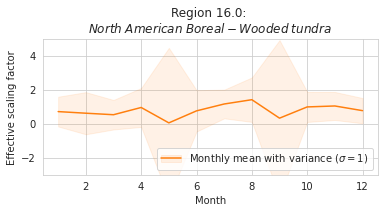

did not find a match in any of xarray's currently installed IO backends ['h5netcdf', 'scipy']. Consider explicitly selecting one of the installed engines via the ``engine`` parameter, or installing additional IO dependencies, see:
https://docs.xarray.dev/en/stable/getting-started-guide/installing.html
https://docs.xarray.dev/en/stable/user-guide/io.html
The loaded file contained an incompatible model. Training a new model
starting training process of monthly model, at eco-region 10.0 using data starting at 2011


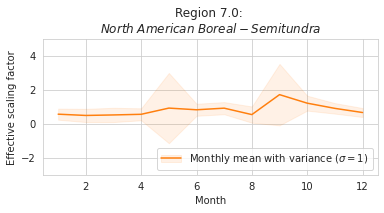

did not find a match in any of xarray's currently installed IO backends ['h5netcdf', 'scipy']. Consider explicitly selecting one of the installed engines via the ``engine`` parameter, or installing additional IO dependencies, see:
https://docs.xarray.dev/en/stable/getting-started-guide/installing.html
https://docs.xarray.dev/en/stable/user-guide/io.html
The loaded file contained an incompatible model. Training a new model
starting training process of monthly model, at eco-region 16.0 using data starting at 2012


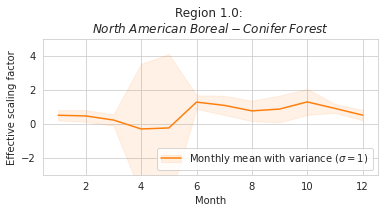

did not find a match in any of xarray's currently installed IO backends ['h5netcdf', 'scipy']. Consider explicitly selecting one of the installed engines via the ``engine`` parameter, or installing additional IO dependencies, see:
https://docs.xarray.dev/en/stable/getting-started-guide/installing.html
https://docs.xarray.dev/en/stable/user-guide/io.html
The loaded file contained an incompatible model. Training a new model
starting training process of monthly model, at eco-region 7.0 using data starting at 2013
did not find a match in any of xarray's currently installed IO backends ['h5netcdf', 'scipy']. Consider explicitly selecting one of the installed engines via the ``engine`` parameter, or installing additional IO dependencies, see:
https://docs.xarray.dev/en/stable/getting-started-guide/installing.html
https://docs.xarray.dev/en/stable/user-guide/io.html
The loaded file contained an incompatible model. Training a new model
starting training process of monthly model, at eco-region 

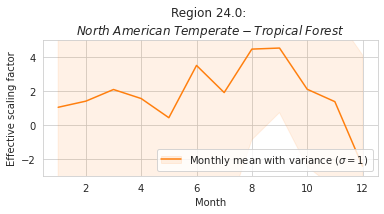

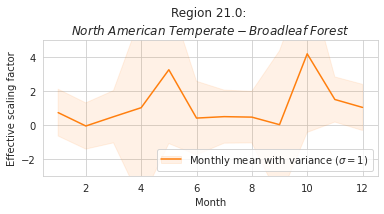

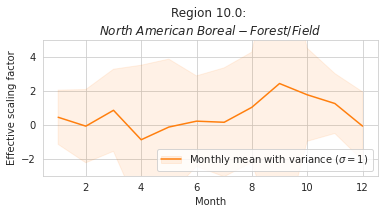

did not find a match in any of xarray's currently installed IO backends ['h5netcdf', 'scipy']. Consider explicitly selecting one of the installed engines via the ``engine`` parameter, or installing additional IO dependencies, see:
https://docs.xarray.dev/en/stable/getting-started-guide/installing.html
https://docs.xarray.dev/en/stable/user-guide/io.html
The loaded file contained an incompatible model. Training a new model
starting training process of monthly model, at eco-region 24.0 using data starting at 2013
did not find a match in any of xarray's currently installed IO backends ['h5netcdf', 'scipy']. Consider explicitly selecting one of the installed engines via the ``engine`` parameter, or installing additional IO dependencies, see:
https://docs.xarray.dev/en/stable/getting-started-guide/installing.html
https://docs.xarray.dev/en/stable/user-guide/io.html
The loaded file contained an incompatible model. Training a new model
starting training process of monthly model, at eco-region

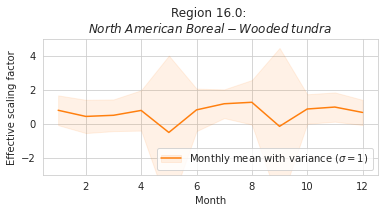

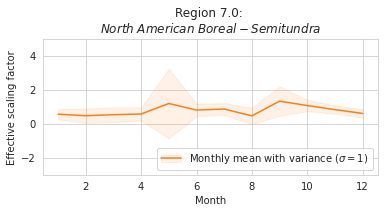

did not find a match in any of xarray's currently installed IO backends ['h5netcdf', 'scipy']. Consider explicitly selecting one of the installed engines via the ``engine`` parameter, or installing additional IO dependencies, see:
https://docs.xarray.dev/en/stable/getting-started-guide/installing.html
https://docs.xarray.dev/en/stable/user-guide/io.html
The loaded file contained an incompatible model. Training a new model
starting training process of monthly model, at eco-region 10.0 using data starting at 2012


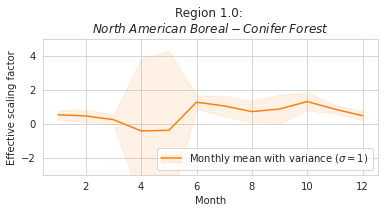

did not find a match in any of xarray's currently installed IO backends ['h5netcdf', 'scipy']. Consider explicitly selecting one of the installed engines via the ``engine`` parameter, or installing additional IO dependencies, see:
https://docs.xarray.dev/en/stable/getting-started-guide/installing.html
https://docs.xarray.dev/en/stable/user-guide/io.html
The loaded file contained an incompatible model. Training a new model
starting training process of monthly model, at eco-region 16.0 using data starting at 2013
did not find a match in any of xarray's currently installed IO backends ['h5netcdf', 'scipy']. Consider explicitly selecting one of the installed engines via the ``engine`` parameter, or installing additional IO dependencies, see:
https://docs.xarray.dev/en/stable/getting-started-guide/installing.html
https://docs.xarray.dev/en/stable/user-guide/io.html
The loaded file contained an incompatible model. Training a new model
starting training process of monthly model, at eco-region

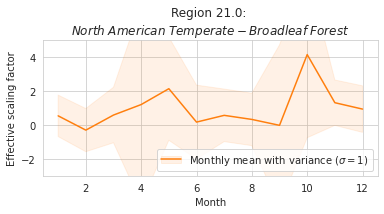

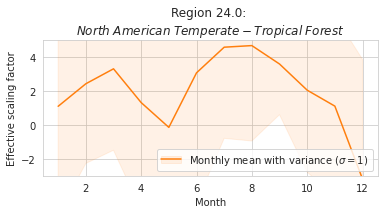

did not find a match in any of xarray's currently installed IO backends ['h5netcdf', 'scipy']. Consider explicitly selecting one of the installed engines via the ``engine`` parameter, or installing additional IO dependencies, see:
https://docs.xarray.dev/en/stable/getting-started-guide/installing.html
https://docs.xarray.dev/en/stable/user-guide/io.html
The loaded file contained an incompatible model. Training a new model
starting training process of monthly model, at eco-region 21.0 using data starting at 2013


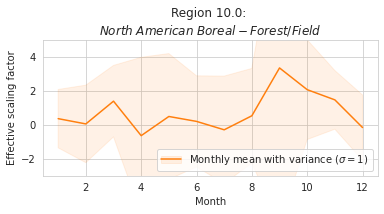

did not find a match in any of xarray's currently installed IO backends ['h5netcdf', 'scipy']. Consider explicitly selecting one of the installed engines via the ``engine`` parameter, or installing additional IO dependencies, see:
https://docs.xarray.dev/en/stable/getting-started-guide/installing.html
https://docs.xarray.dev/en/stable/user-guide/io.html
The loaded file contained an incompatible model. Training a new model
starting training process of monthly model, at eco-region 24.0 using data starting at 2014


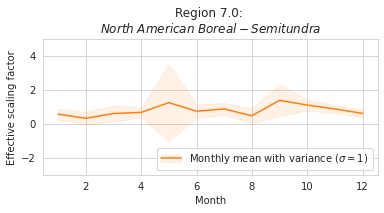

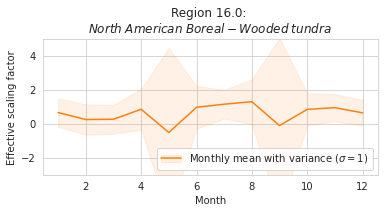

did not find a match in any of xarray's currently installed IO backends ['h5netcdf', 'scipy']. Consider explicitly selecting one of the installed engines via the ``engine`` parameter, or installing additional IO dependencies, see:
https://docs.xarray.dev/en/stable/getting-started-guide/installing.html
https://docs.xarray.dev/en/stable/user-guide/io.html
The loaded file contained an incompatible model. Training a new model
starting training process of monthly model, at eco-region 10.0 using data starting at 2013


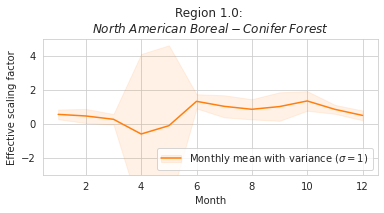

did not find a match in any of xarray's currently installed IO backends ['h5netcdf', 'scipy']. Consider explicitly selecting one of the installed engines via the ``engine`` parameter, or installing additional IO dependencies, see:
https://docs.xarray.dev/en/stable/getting-started-guide/installing.html
https://docs.xarray.dev/en/stable/user-guide/io.html
The loaded file contained an incompatible model. Training a new model
starting training process of monthly model, at eco-region 7.0 using data starting at 2015
did not find a match in any of xarray's currently installed IO backends ['h5netcdf', 'scipy']. Consider explicitly selecting one of the installed engines via the ``engine`` parameter, or installing additional IO dependencies, see:
https://docs.xarray.dev/en/stable/getting-started-guide/installing.html
https://docs.xarray.dev/en/stable/user-guide/io.html
The loaded file contained an incompatible model. Training a new model
starting training process of monthly model, at eco-region 

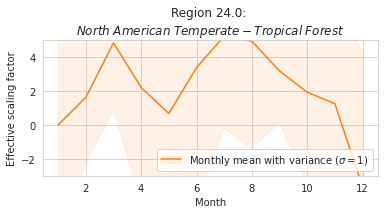

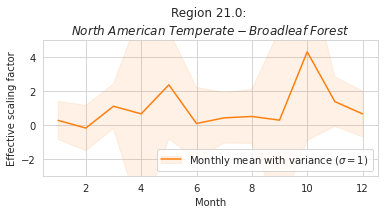

did not find a match in any of xarray's currently installed IO backends ['h5netcdf', 'scipy']. Consider explicitly selecting one of the installed engines via the ``engine`` parameter, or installing additional IO dependencies, see:
https://docs.xarray.dev/en/stable/getting-started-guide/installing.html
https://docs.xarray.dev/en/stable/user-guide/io.html
The loaded file contained an incompatible model. Training a new model
starting training process of monthly model, at eco-region 24.0 using data starting at 2015


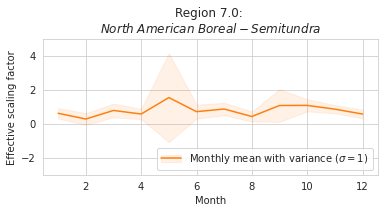

did not find a match in any of xarray's currently installed IO backends ['h5netcdf', 'scipy']. Consider explicitly selecting one of the installed engines via the ``engine`` parameter, or installing additional IO dependencies, see:
https://docs.xarray.dev/en/stable/getting-started-guide/installing.html
https://docs.xarray.dev/en/stable/user-guide/io.html
The loaded file contained an incompatible model. Training a new model
starting training process of monthly model, at eco-region 21.0 using data starting at 2014


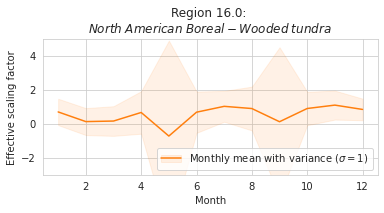

did not find a match in any of xarray's currently installed IO backends ['h5netcdf', 'scipy']. Consider explicitly selecting one of the installed engines via the ``engine`` parameter, or installing additional IO dependencies, see:
https://docs.xarray.dev/en/stable/getting-started-guide/installing.html
https://docs.xarray.dev/en/stable/user-guide/io.html
The loaded file contained an incompatible model. Training a new model
starting training process of monthly model, at eco-region 7.0 using data starting at 2016
did not find a match in any of xarray's currently installed IO backends ['h5netcdf', 'scipy']. Consider explicitly selecting one of the installed engines via the ``engine`` parameter, or installing additional IO dependencies, see:
https://docs.xarray.dev/en/stable/getting-started-guide/installing.html
https://docs.xarray.dev/en/stable/user-guide/io.html


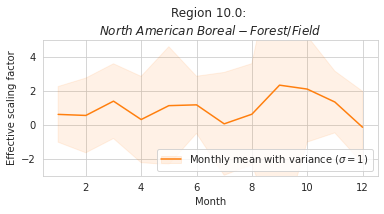

The loaded file contained an incompatible model. Training a new model
starting training process of monthly model, at eco-region 16.0 using data starting at 2015


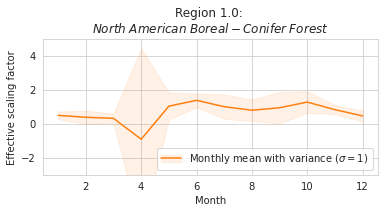

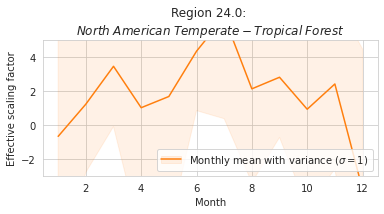

did not find a match in any of xarray's currently installed IO backends ['h5netcdf', 'scipy']. Consider explicitly selecting one of the installed engines via the ``engine`` parameter, or installing additional IO dependencies, see:
https://docs.xarray.dev/en/stable/getting-started-guide/installing.html
https://docs.xarray.dev/en/stable/user-guide/io.html
The loaded file contained an incompatible model. Training a new model
starting training process of monthly model, at eco-region 10.0 using data starting at 2014
did not find a match in any of xarray's currently installed IO backends ['h5netcdf', 'scipy']. Consider explicitly selecting one of the installed engines via the ``engine`` parameter, or installing additional IO dependencies, see:
https://docs.xarray.dev/en/stable/getting-started-guide/installing.html
https://docs.xarray.dev/en/stable/user-guide/io.html
The loaded file contained an incompatible model. Training a new model
starting training process of monthly model, at eco-region

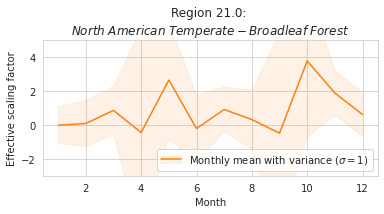

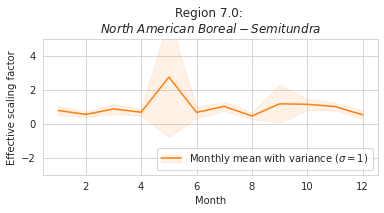

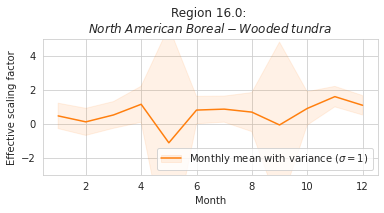

did not find a match in any of xarray's currently installed IO backends ['h5netcdf', 'scipy']. Consider explicitly selecting one of the installed engines via the ``engine`` parameter, or installing additional IO dependencies, see:
https://docs.xarray.dev/en/stable/getting-started-guide/installing.html
https://docs.xarray.dev/en/stable/user-guide/io.html
The loaded file contained an incompatible model. Training a new model
starting training process of monthly model, at eco-region 21.0 using data starting at 2015
did not find a match in any of xarray's currently installed IO backends ['h5netcdf', 'scipy']. Consider explicitly selecting one of the installed engines via the ``engine`` parameter, or installing additional IO dependencies, see:
https://docs.xarray.dev/en/stable/getting-started-guide/installing.html
https://docs.xarray.dev/en/stable/user-guide/io.html
The loaded file contained an incompatible model. Training a new model
starting training process of monthly model, at eco-region

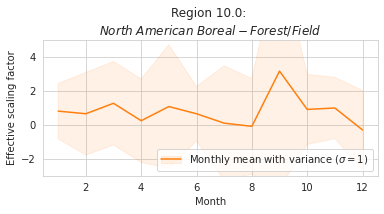

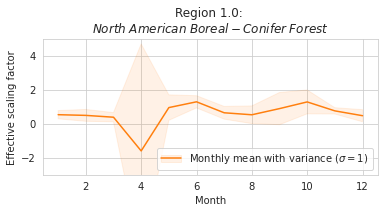

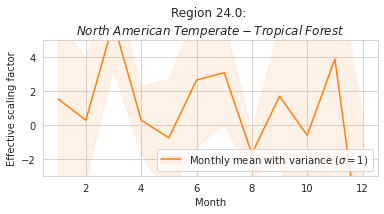

Finished writing results for region 7.0
Determining sf prediction of region 8.0
did not find a match in any of xarray's currently installed IO backends ['h5netcdf', 'scipy']. Consider explicitly selecting one of the installed engines via the ``engine`` parameter, or installing additional IO dependencies, see:
https://docs.xarray.dev/en/stable/getting-started-guide/installing.html
https://docs.xarray.dev/en/stable/user-guide/io.htmlNo sf data exists on region 8.0. Making new sf prediction

The loaded file contained an incompatible model. Training a new modeldid not find a match in any of xarray's currently installed IO backends ['h5netcdf', 'scipy']. Consider explicitly selecting one of the installed engines via the ``engine`` parameter, or installing additional IO dependencies, see:
https://docs.xarray.dev/en/stable/getting-started-guide/installing.html
https://docs.xarray.dev/en/stable/user-guide/io.html

starting training process of monthly model, at eco-region 10.0 using data starti

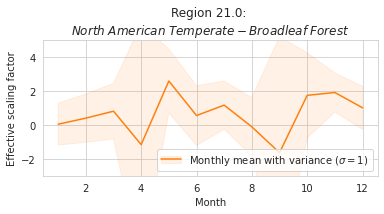

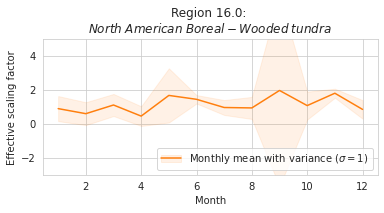

Finished writing results for region 24.0
Determining sf prediction of region 25.0
No sf data exists on region 25.0. Making new sf prediction
did not find a match in any of xarray's currently installed IO backends ['h5netcdf', 'scipy']. Consider explicitly selecting one of the installed engines via the ``engine`` parameter, or installing additional IO dependencies, see:
https://docs.xarray.dev/en/stable/getting-started-guide/installing.html
https://docs.xarray.dev/en/stable/user-guide/io.html
The loaded file contained an incompatible model. Training a new model
starting training process of monthly model, at eco-region 25.0 using data starting at 2000
did not find a match in any of xarray's currently installed IO backends ['h5netcdf', 'scipy']. Consider explicitly selecting one of the installed engines via the ``engine`` parameter, or installing additional IO dependencies, see:
https://docs.xarray.dev/en/stable/getting-started-guide/installing.html
https://docs.xarray.dev/en/stable/user-

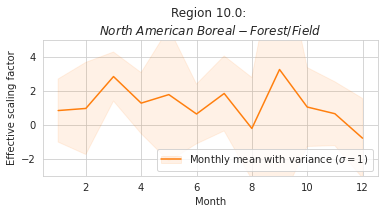

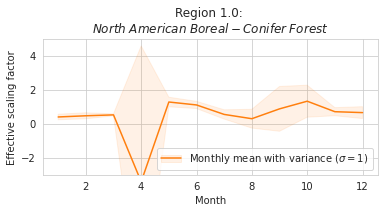

Finished writing results for region 16.0
Determining sf prediction of region 19.0
No sf data exists on region 19.0. Making new sf prediction
did not find a match in any of xarray's currently installed IO backends ['h5netcdf', 'scipy']. Consider explicitly selecting one of the installed engines via the ``engine`` parameter, or installing additional IO dependencies, see:
https://docs.xarray.dev/en/stable/getting-started-guide/installing.html
https://docs.xarray.dev/en/stable/user-guide/io.html
The loaded file contained an incompatible model. Training a new model
starting training process of monthly model, at eco-region 19.0 using data starting at 2000
did not find a match in any of xarray's currently installed IO backends ['h5netcdf', 'scipy']. Consider explicitly selecting one of the installed engines via the ``engine`` parameter, or installing additional IO dependencies, see:
https://docs.xarray.dev/en/stable/getting-started-guide/installing.html
https://docs.xarray.dev/en/stable/user-

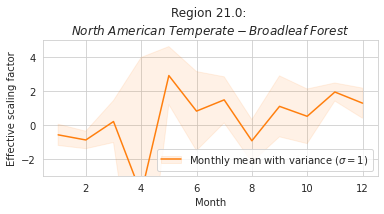

Finished writing results for region 1.0
Determining sf prediction of region 3.0
No sf data exists on region 3.0. Making new sf prediction
did not find a match in any of xarray's currently installed IO backends ['h5netcdf', 'scipy']. Consider explicitly selecting one of the installed engines via the ``engine`` parameter, or installing additional IO dependencies, see:
https://docs.xarray.dev/en/stable/getting-started-guide/installing.html
https://docs.xarray.dev/en/stable/user-guide/io.html
The loaded file contained an incompatible model. Training a new model
starting training process of monthly model, at eco-region 3.0 using data starting at 2000
writing intermediate results for region 21.0


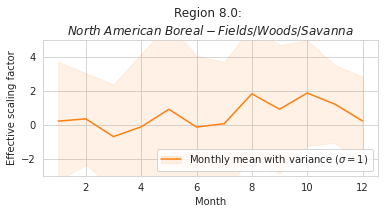

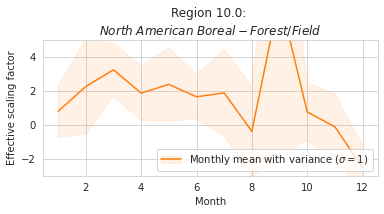

Finished writing results for region 21.0
Determining sf prediction of region 22.0
No sf data exists on region 22.0. Making new sf prediction
did not find a match in any of xarray's currently installed IO backends ['h5netcdf', 'scipy']. Consider explicitly selecting one of the installed engines via the ``engine`` parameter, or installing additional IO dependencies, see:
https://docs.xarray.dev/en/stable/getting-started-guide/installing.html
https://docs.xarray.dev/en/stable/user-guide/io.html
The loaded file contained an incompatible model. Training a new model
starting training process of monthly model, at eco-region 22.0 using data starting at 2000
did not find a match in any of xarray's currently installed IO backends ['h5netcdf', 'scipy']. Consider explicitly selecting one of the installed engines via the ``engine`` parameter, or installing additional IO dependencies, see:
https://docs.xarray.dev/en/stable/getting-started-guide/installing.html
https://docs.xarray.dev/en/stable/user-

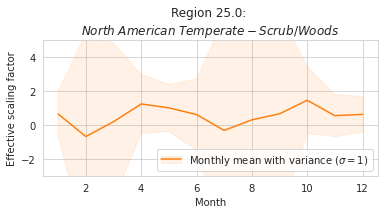

Finished writing results for region 10.0
Determining sf prediction of region 11.0
No sf data exists on region 11.0. Making new sf prediction
did not find a match in any of xarray's currently installed IO backends ['h5netcdf', 'scipy']. Consider explicitly selecting one of the installed engines via the ``engine`` parameter, or installing additional IO dependencies, see:
https://docs.xarray.dev/en/stable/getting-started-guide/installing.html
https://docs.xarray.dev/en/stable/user-guide/io.html
The loaded file contained an incompatible model. Training a new model
starting training process of monthly model, at eco-region 11.0 using data starting at 2000


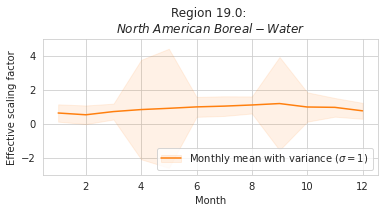

did not find a match in any of xarray's currently installed IO backends ['h5netcdf', 'scipy']. Consider explicitly selecting one of the installed engines via the ``engine`` parameter, or installing additional IO dependencies, see:
https://docs.xarray.dev/en/stable/getting-started-guide/installing.html
https://docs.xarray.dev/en/stable/user-guide/io.html
The loaded file contained an incompatible model. Training a new model
starting training process of monthly model, at eco-region 25.0 using data starting at 2001


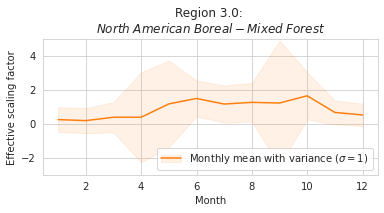

did not find a match in any of xarray's currently installed IO backends ['h5netcdf', 'scipy']. Consider explicitly selecting one of the installed engines via the ``engine`` parameter, or installing additional IO dependencies, see:
https://docs.xarray.dev/en/stable/getting-started-guide/installing.html
https://docs.xarray.dev/en/stable/user-guide/io.html
The loaded file contained an incompatible model. Training a new model
starting training process of monthly model, at eco-region 19.0 using data starting at 2001
did not find a match in any of xarray's currently installed IO backends ['h5netcdf', 'scipy']. Consider explicitly selecting one of the installed engines via the ``engine`` parameter, or installing additional IO dependencies, see:
https://docs.xarray.dev/en/stable/getting-started-guide/installing.html
https://docs.xarray.dev/en/stable/user-guide/io.html

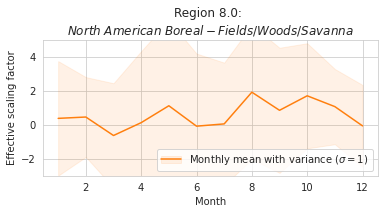


The loaded file contained an incompatible model. Training a new model
starting training process of monthly model, at eco-region 3.0 using data starting at 2001


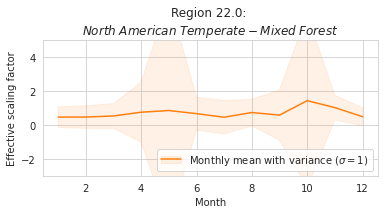

did not find a match in any of xarray's currently installed IO backends ['h5netcdf', 'scipy']. Consider explicitly selecting one of the installed engines via the ``engine`` parameter, or installing additional IO dependencies, see:
https://docs.xarray.dev/en/stable/getting-started-guide/installing.html
https://docs.xarray.dev/en/stable/user-guide/io.html
The loaded file contained an incompatible model. Training a new model
starting training process of monthly model, at eco-region 8.0 using data starting at 2002
did not find a match in any of xarray's currently installed IO backends ['h5netcdf', 'scipy']. Consider explicitly selecting one of the installed engines via the ``engine`` parameter, or installing additional IO dependencies, see:
https://docs.xarray.dev/en/stable/getting-started-guide/installing.html
https://docs.xarray.dev/en/stable/user-guide/io.html

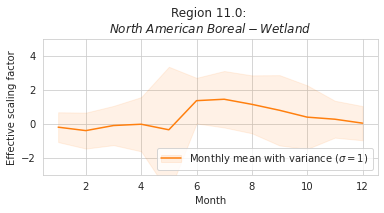


The loaded file contained an incompatible model. Training a new model
starting training process of monthly model, at eco-region 22.0 using data starting at 2001


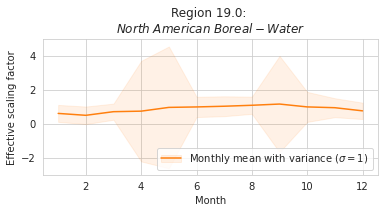

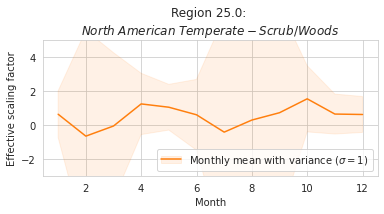

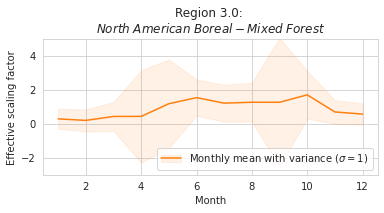

did not find a match in any of xarray's currently installed IO backends ['h5netcdf', 'scipy']. Consider explicitly selecting one of the installed engines via the ``engine`` parameter, or installing additional IO dependencies, see:
https://docs.xarray.dev/en/stable/getting-started-guide/installing.html
https://docs.xarray.dev/en/stable/user-guide/io.html
The loaded file contained an incompatible model. Training a new model
starting training process of monthly model, at eco-region 11.0 using data starting at 2001
did not find a match in any of xarray's currently installed IO backends ['h5netcdf', 'scipy']. Consider explicitly selecting one of the installed engines via the ``engine`` parameter, or installing additional IO dependencies, see:
https://docs.xarray.dev/en/stable/getting-started-guide/installing.html
https://docs.xarray.dev/en/stable/user-guide/io.html
The loaded file contained an incompatible model. Training a new model
starting training process of monthly model, at eco-region

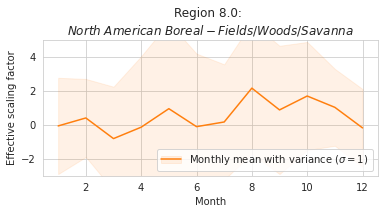

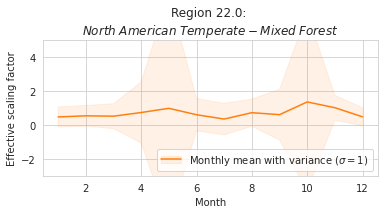

did not find a match in any of xarray's currently installed IO backends ['h5netcdf', 'scipy']. Consider explicitly selecting one of the installed engines via the ``engine`` parameter, or installing additional IO dependencies, see:
https://docs.xarray.dev/en/stable/getting-started-guide/installing.html
https://docs.xarray.dev/en/stable/user-guide/io.html
The loaded file contained an incompatible model. Training a new model
starting training process of monthly model, at eco-region 8.0 using data starting at 2003


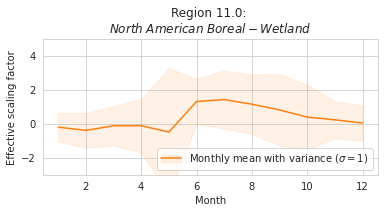

did not find a match in any of xarray's currently installed IO backends ['h5netcdf', 'scipy']. Consider explicitly selecting one of the installed engines via the ``engine`` parameter, or installing additional IO dependencies, see:
https://docs.xarray.dev/en/stable/getting-started-guide/installing.html
https://docs.xarray.dev/en/stable/user-guide/io.html
The loaded file contained an incompatible model. Training a new model
starting training process of monthly model, at eco-region 22.0 using data starting at 2002


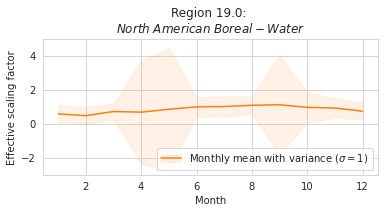

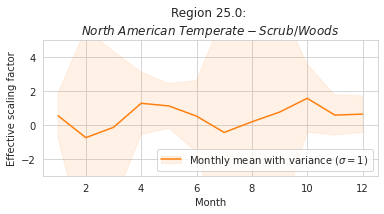

did not find a match in any of xarray's currently installed IO backends ['h5netcdf', 'scipy']. Consider explicitly selecting one of the installed engines via the ``engine`` parameter, or installing additional IO dependencies, see:
https://docs.xarray.dev/en/stable/getting-started-guide/installing.html
https://docs.xarray.dev/en/stable/user-guide/io.html
The loaded file contained an incompatible model. Training a new model
starting training process of monthly model, at eco-region 11.0 using data starting at 2002
did not find a match in any of xarray's currently installed IO backends ['h5netcdf', 'scipy']. Consider explicitly selecting one of the installed engines via the ``engine`` parameter, or installing additional IO dependencies, see:
https://docs.xarray.dev/en/stable/getting-started-guide/installing.html
https://docs.xarray.dev/en/stable/user-guide/io.html
The loaded file contained an incompatible model. Training a new model
starting training process of monthly model, at eco-region

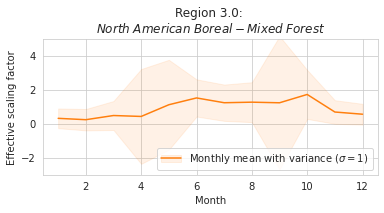

did not find a match in any of xarray's currently installed IO backends ['h5netcdf', 'scipy']. Consider explicitly selecting one of the installed engines via the ``engine`` parameter, or installing additional IO dependencies, see:
https://docs.xarray.dev/en/stable/getting-started-guide/installing.html
https://docs.xarray.dev/en/stable/user-guide/io.html
The loaded file contained an incompatible model. Training a new model
starting training process of monthly model, at eco-region 25.0 using data starting at 2003


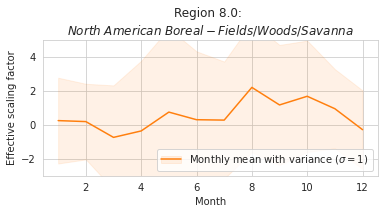

did not find a match in any of xarray's currently installed IO backends ['h5netcdf', 'scipy']. Consider explicitly selecting one of the installed engines via the ``engine`` parameter, or installing additional IO dependencies, see:
https://docs.xarray.dev/en/stable/getting-started-guide/installing.html
https://docs.xarray.dev/en/stable/user-guide/io.html
The loaded file contained an incompatible model. Training a new model
starting training process of monthly model, at eco-region 3.0 using data starting at 2003


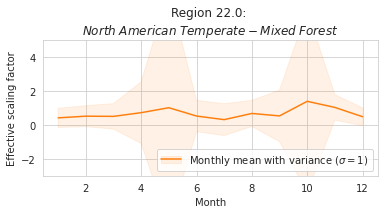

did not find a match in any of xarray's currently installed IO backends ['h5netcdf', 'scipy']. Consider explicitly selecting one of the installed engines via the ``engine`` parameter, or installing additional IO dependencies, see:
https://docs.xarray.dev/en/stable/getting-started-guide/installing.html
https://docs.xarray.dev/en/stable/user-guide/io.html
The loaded file contained an incompatible model. Training a new model
starting training process of monthly model, at eco-region 8.0 using data starting at 2004


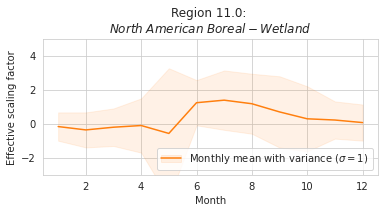

did not find a match in any of xarray's currently installed IO backends ['h5netcdf', 'scipy']. Consider explicitly selecting one of the installed engines via the ``engine`` parameter, or installing additional IO dependencies, see:
https://docs.xarray.dev/en/stable/getting-started-guide/installing.html
https://docs.xarray.dev/en/stable/user-guide/io.html
The loaded file contained an incompatible model. Training a new model
starting training process of monthly model, at eco-region 22.0 using data starting at 2003
did not find a match in any of xarray's currently installed IO backends ['h5netcdf', 'scipy']. Consider explicitly selecting one of the installed engines via the ``engine`` parameter, or installing additional IO dependencies, see:
https://docs.xarray.dev/en/stable/getting-started-guide/installing.html
https://docs.xarray.dev/en/stable/user-guide/io.html
The loaded file contained an incompatible model. Training a new model
starting training process of monthly model, at eco-region

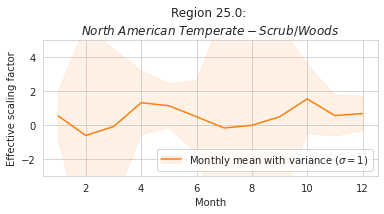

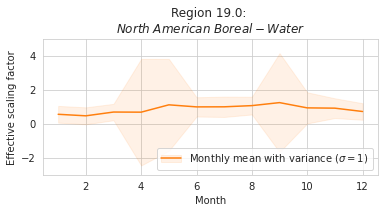

did not find a match in any of xarray's currently installed IO backends ['h5netcdf', 'scipy']. Consider explicitly selecting one of the installed engines via the ``engine`` parameter, or installing additional IO dependencies, see:
https://docs.xarray.dev/en/stable/getting-started-guide/installing.html
https://docs.xarray.dev/en/stable/user-guide/io.html
The loaded file contained an incompatible model. Training a new model
starting training process of monthly model, at eco-region 25.0 using data starting at 2004
did not find a match in any of xarray's currently installed IO backends ['h5netcdf', 'scipy']. Consider explicitly selecting one of the installed engines via the ``engine`` parameter, or installing additional IO dependencies, see:
https://docs.xarray.dev/en/stable/getting-started-guide/installing.html
https://docs.xarray.dev/en/stable/user-guide/io.html
The loaded file contained an incompatible model. Training a new model
starting training process of monthly model, at eco-region

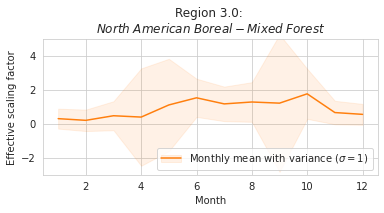

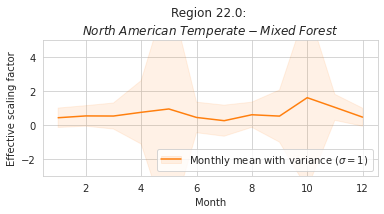

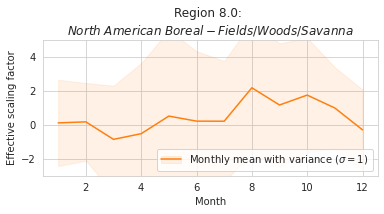

did not find a match in any of xarray's currently installed IO backends ['h5netcdf', 'scipy']. Consider explicitly selecting one of the installed engines via the ``engine`` parameter, or installing additional IO dependencies, see:
https://docs.xarray.dev/en/stable/getting-started-guide/installing.html
https://docs.xarray.dev/en/stable/user-guide/io.html
The loaded file contained an incompatible model. Training a new model
starting training process of monthly model, at eco-region 3.0 using data starting at 2004


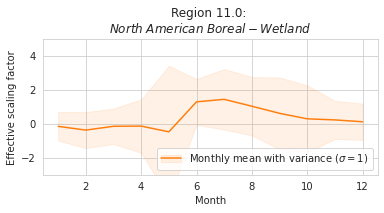

did not find a match in any of xarray's currently installed IO backends ['h5netcdf', 'scipy']. Consider explicitly selecting one of the installed engines via the ``engine`` parameter, or installing additional IO dependencies, see:
https://docs.xarray.dev/en/stable/getting-started-guide/installing.html
https://docs.xarray.dev/en/stable/user-guide/io.html
The loaded file contained an incompatible model. Training a new model
starting training process of monthly model, at eco-region 22.0 using data starting at 2004
did not find a match in any of xarray's currently installed IO backends ['h5netcdf', 'scipy']. Consider explicitly selecting one of the installed engines via the ``engine`` parameter, or installing additional IO dependencies, see:
https://docs.xarray.dev/en/stable/getting-started-guide/installing.html
https://docs.xarray.dev/en/stable/user-guide/io.html
The loaded file contained an incompatible model. Training a new model
starting training process of monthly model, at eco-region

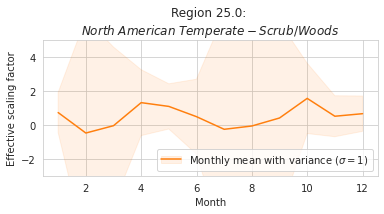

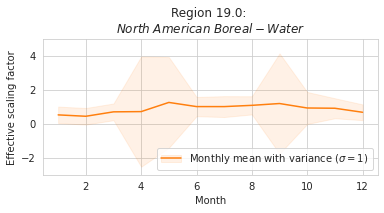

did not find a match in any of xarray's currently installed IO backends ['h5netcdf', 'scipy']. Consider explicitly selecting one of the installed engines via the ``engine`` parameter, or installing additional IO dependencies, see:
https://docs.xarray.dev/en/stable/getting-started-guide/installing.html
https://docs.xarray.dev/en/stable/user-guide/io.html
The loaded file contained an incompatible model. Training a new model
starting training process of monthly model, at eco-region 11.0 using data starting at 2004
did not find a match in any of xarray's currently installed IO backends ['h5netcdf', 'scipy']. Consider explicitly selecting one of the installed engines via the ``engine`` parameter, or installing additional IO dependencies, see:
https://docs.xarray.dev/en/stable/getting-started-guide/installing.html
https://docs.xarray.dev/en/stable/user-guide/io.html
The loaded file contained an incompatible model. Training a new model
starting training process of monthly model, at eco-region

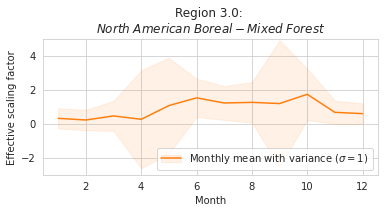

did not find a match in any of xarray's currently installed IO backends ['h5netcdf', 'scipy']. Consider explicitly selecting one of the installed engines via the ``engine`` parameter, or installing additional IO dependencies, see:
https://docs.xarray.dev/en/stable/getting-started-guide/installing.html
https://docs.xarray.dev/en/stable/user-guide/io.html
The loaded file contained an incompatible model. Training a new model
starting training process of monthly model, at eco-region 19.0 using data starting at 2005
did not find a match in any of xarray's currently installed IO backends ['h5netcdf', 'scipy']. Consider explicitly selecting one of the installed engines via the ``engine`` parameter, or installing additional IO dependencies, see:
https://docs.xarray.dev/en/stable/getting-started-guide/installing.html
https://docs.xarray.dev/en/stable/user-guide/io.html
The loaded file contained an incompatible model. Training a new model
starting training process of monthly model, at eco-region

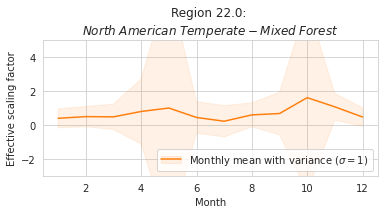

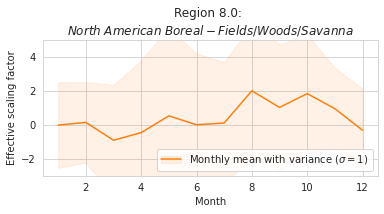

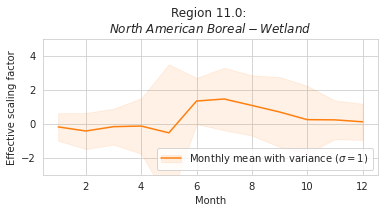

did not find a match in any of xarray's currently installed IO backends ['h5netcdf', 'scipy']. Consider explicitly selecting one of the installed engines via the ``engine`` parameter, or installing additional IO dependencies, see:
https://docs.xarray.dev/en/stable/getting-started-guide/installing.html
https://docs.xarray.dev/en/stable/user-guide/io.html
The loaded file contained an incompatible model. Training a new model
starting training process of monthly model, at eco-region 22.0 using data starting at 2005
did not find a match in any of xarray's currently installed IO backends ['h5netcdf', 'scipy']. Consider explicitly selecting one of the installed engines via the ``engine`` parameter, or installing additional IO dependencies, see:
https://docs.xarray.dev/en/stable/getting-started-guide/installing.html
https://docs.xarray.dev/en/stable/user-guide/io.html
The loaded file contained an incompatible model. Training a new model
starting training process of monthly model, at eco-region

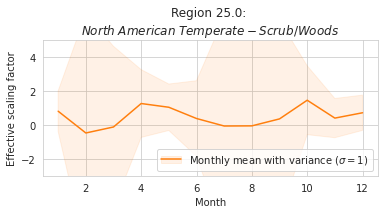

did not find a match in any of xarray's currently installed IO backends ['h5netcdf', 'scipy']. Consider explicitly selecting one of the installed engines via the ``engine`` parameter, or installing additional IO dependencies, see:
https://docs.xarray.dev/en/stable/getting-started-guide/installing.html
https://docs.xarray.dev/en/stable/user-guide/io.html
The loaded file contained an incompatible model. Training a new model
starting training process of monthly model, at eco-region 11.0 using data starting at 2005


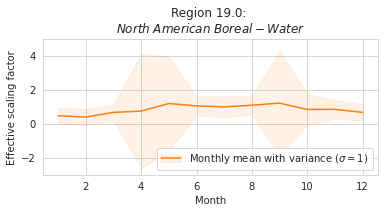

did not find a match in any of xarray's currently installed IO backends ['h5netcdf', 'scipy']. Consider explicitly selecting one of the installed engines via the ``engine`` parameter, or installing additional IO dependencies, see:
https://docs.xarray.dev/en/stable/getting-started-guide/installing.html
https://docs.xarray.dev/en/stable/user-guide/io.html
The loaded file contained an incompatible model. Training a new model
starting training process of monthly model, at eco-region 25.0 using data starting at 2006


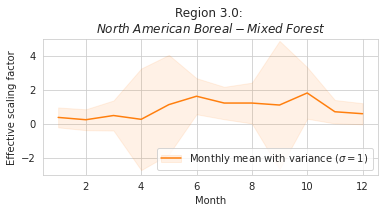

did not find a match in any of xarray's currently installed IO backends ['h5netcdf', 'scipy']. Consider explicitly selecting one of the installed engines via the ``engine`` parameter, or installing additional IO dependencies, see:
https://docs.xarray.dev/en/stable/getting-started-guide/installing.html
https://docs.xarray.dev/en/stable/user-guide/io.html
The loaded file contained an incompatible model. Training a new model
starting training process of monthly model, at eco-region 19.0 using data starting at 2006


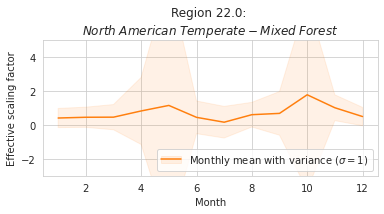

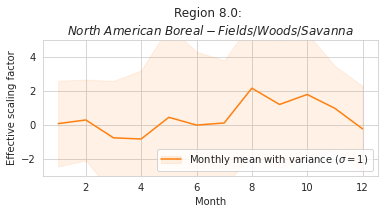

did not find a match in any of xarray's currently installed IO backends ['h5netcdf', 'scipy']. Consider explicitly selecting one of the installed engines via the ``engine`` parameter, or installing additional IO dependencies, see:
https://docs.xarray.dev/en/stable/getting-started-guide/installing.html
https://docs.xarray.dev/en/stable/user-guide/io.html
The loaded file contained an incompatible model. Training a new model
starting training process of monthly model, at eco-region 3.0 using data starting at 2006


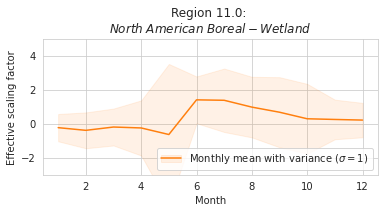

did not find a match in any of xarray's currently installed IO backends ['h5netcdf', 'scipy']. Consider explicitly selecting one of the installed engines via the ``engine`` parameter, or installing additional IO dependencies, see:
https://docs.xarray.dev/en/stable/getting-started-guide/installing.html
https://docs.xarray.dev/en/stable/user-guide/io.html
The loaded file contained an incompatible model. Training a new model
did not find a match in any of xarray's currently installed IO backends ['h5netcdf', 'scipy']. Consider explicitly selecting one of the installed engines via the ``engine`` parameter, or installing additional IO dependencies, see:
https://docs.xarray.dev/en/stable/getting-started-guide/installing.html
https://docs.xarray.dev/en/stable/user-guide/io.html
starting training process of monthly model, at eco-region 22.0 using data starting at 2006
The loaded file contained an incompatible model. Training a new model
starting training process of monthly model, at eco-region

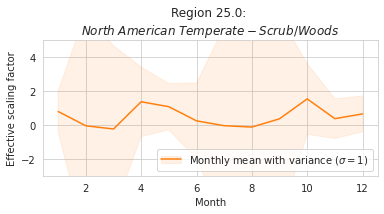

did not find a match in any of xarray's currently installed IO backends ['h5netcdf', 'scipy']. Consider explicitly selecting one of the installed engines via the ``engine`` parameter, or installing additional IO dependencies, see:
https://docs.xarray.dev/en/stable/getting-started-guide/installing.html
https://docs.xarray.dev/en/stable/user-guide/io.html
The loaded file contained an incompatible model. Training a new model
starting training process of monthly model, at eco-region 11.0 using data starting at 2006


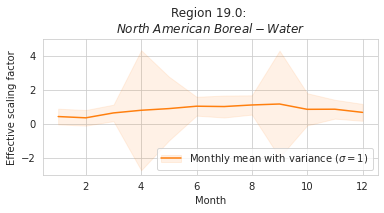

did not find a match in any of xarray's currently installed IO backends ['h5netcdf', 'scipy']. Consider explicitly selecting one of the installed engines via the ``engine`` parameter, or installing additional IO dependencies, see:
https://docs.xarray.dev/en/stable/getting-started-guide/installing.html
https://docs.xarray.dev/en/stable/user-guide/io.html
The loaded file contained an incompatible model. Training a new model
starting training process of monthly model, at eco-region 25.0 using data starting at 2007
did not find a match in any of xarray's currently installed IO backends ['h5netcdf', 'scipy']. Consider explicitly selecting one of the installed engines via the ``engine`` parameter, or installing additional IO dependencies, see:
https://docs.xarray.dev/en/stable/getting-started-guide/installing.html
https://docs.xarray.dev/en/stable/user-guide/io.html
The loaded file contained an incompatible model. Training a new model
starting training process of monthly model, at eco-region

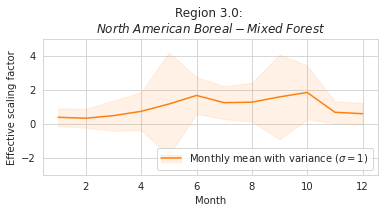

did not find a match in any of xarray's currently installed IO backends ['h5netcdf', 'scipy']. Consider explicitly selecting one of the installed engines via the ``engine`` parameter, or installing additional IO dependencies, see:
https://docs.xarray.dev/en/stable/getting-started-guide/installing.html
https://docs.xarray.dev/en/stable/user-guide/io.html
The loaded file contained an incompatible model. Training a new model


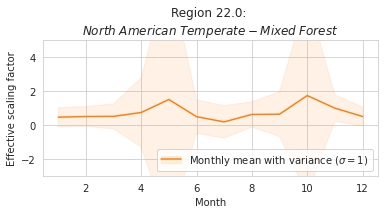

starting training process of monthly model, at eco-region 3.0 using data starting at 2007


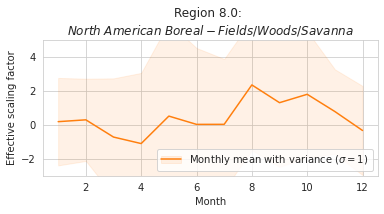

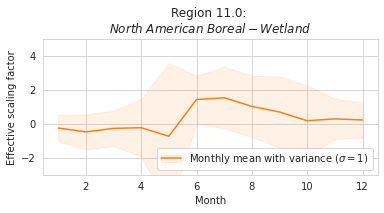

did not find a match in any of xarray's currently installed IO backends ['h5netcdf', 'scipy']. Consider explicitly selecting one of the installed engines via the ``engine`` parameter, or installing additional IO dependencies, see:
https://docs.xarray.dev/en/stable/getting-started-guide/installing.html
https://docs.xarray.dev/en/stable/user-guide/io.html
The loaded file contained an incompatible model. Training a new model
starting training process of monthly model, at eco-region 22.0 using data starting at 2007
did not find a match in any of xarray's currently installed IO backends ['h5netcdf', 'scipy']. Consider explicitly selecting one of the installed engines via the ``engine`` parameter, or installing additional IO dependencies, see:
https://docs.xarray.dev/en/stable/getting-started-guide/installing.html
https://docs.xarray.dev/en/stable/user-guide/io.html
The loaded file contained an incompatible model. Training a new model
starting training process of monthly model, at eco-region

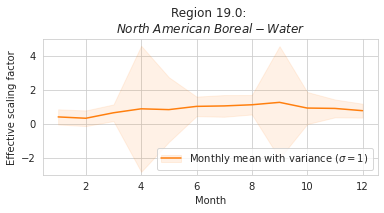

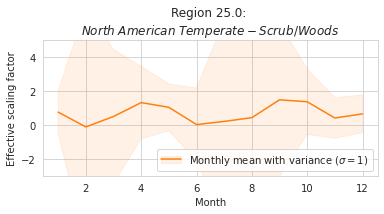

did not find a match in any of xarray's currently installed IO backends ['h5netcdf', 'scipy']. Consider explicitly selecting one of the installed engines via the ``engine`` parameter, or installing additional IO dependencies, see:
https://docs.xarray.dev/en/stable/getting-started-guide/installing.html
https://docs.xarray.dev/en/stable/user-guide/io.html
The loaded file contained an incompatible model. Training a new model
starting training process of monthly model, at eco-region 19.0 using data starting at 2008
did not find a match in any of xarray's currently installed IO backends ['h5netcdf', 'scipy']. Consider explicitly selecting one of the installed engines via the ``engine`` parameter, or installing additional IO dependencies, see:
https://docs.xarray.dev/en/stable/getting-started-guide/installing.html
https://docs.xarray.dev/en/stable/user-guide/io.html
The loaded file contained an incompatible model. Training a new model
starting training process of monthly model, at eco-region

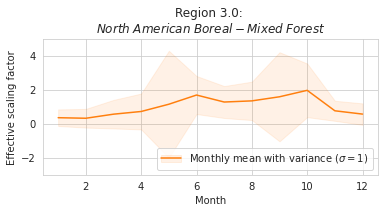

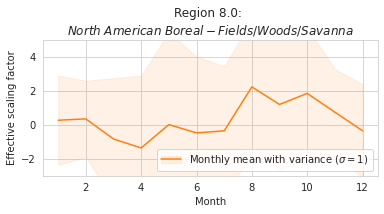

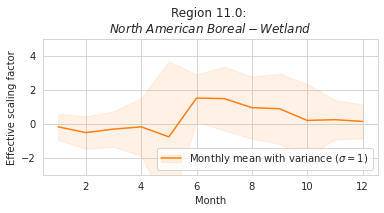

did not find a match in any of xarray's currently installed IO backends ['h5netcdf', 'scipy']. Consider explicitly selecting one of the installed engines via the ``engine`` parameter, or installing additional IO dependencies, see:
https://docs.xarray.dev/en/stable/getting-started-guide/installing.html
https://docs.xarray.dev/en/stable/user-guide/io.html
The loaded file contained an incompatible model. Training a new model
starting training process of monthly model, at eco-region 3.0 using data starting at 2008


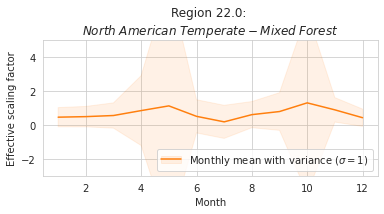

did not find a match in any of xarray's currently installed IO backends ['h5netcdf', 'scipy']. Consider explicitly selecting one of the installed engines via the ``engine`` parameter, or installing additional IO dependencies, see:
https://docs.xarray.dev/en/stable/getting-started-guide/installing.html
https://docs.xarray.dev/en/stable/user-guide/io.html
The loaded file contained an incompatible model. Training a new model
did not find a match in any of xarray's currently installed IO backends ['h5netcdf', 'scipy']. Consider explicitly selecting one of the installed engines via the ``engine`` parameter, or installing additional IO dependencies, see:
https://docs.xarray.dev/en/stable/getting-started-guide/installing.html
https://docs.xarray.dev/en/stable/user-guide/io.htmlstarting training process of monthly model, at eco-region 8.0 using data starting at 2009

The loaded file contained an incompatible model. Training a new model
starting training process of monthly model, at eco-region 

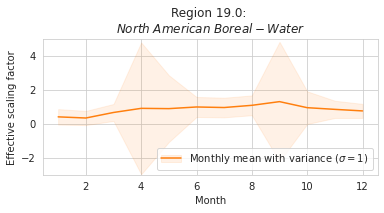

did not find a match in any of xarray's currently installed IO backends ['h5netcdf', 'scipy']. Consider explicitly selecting one of the installed engines via the ``engine`` parameter, or installing additional IO dependencies, see:
https://docs.xarray.dev/en/stable/getting-started-guide/installing.html
https://docs.xarray.dev/en/stable/user-guide/io.html
The loaded file contained an incompatible model. Training a new model
starting training process of monthly model, at eco-region 22.0 using data starting at 2008


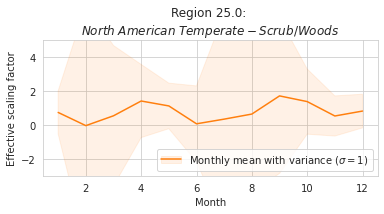

did not find a match in any of xarray's currently installed IO backends ['h5netcdf', 'scipy']. Consider explicitly selecting one of the installed engines via the ``engine`` parameter, or installing additional IO dependencies, see:
https://docs.xarray.dev/en/stable/getting-started-guide/installing.html
https://docs.xarray.dev/en/stable/user-guide/io.html
The loaded file contained an incompatible model. Training a new model
starting training process of monthly model, at eco-region 19.0 using data starting at 2009
did not find a match in any of xarray's currently installed IO backends ['h5netcdf', 'scipy']. Consider explicitly selecting one of the installed engines via the ``engine`` parameter, or installing additional IO dependencies, see:
https://docs.xarray.dev/en/stable/getting-started-guide/installing.html
https://docs.xarray.dev/en/stable/user-guide/io.html
The loaded file contained an incompatible model. Training a new model
starting training process of monthly model, at eco-region

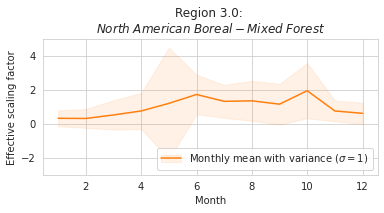

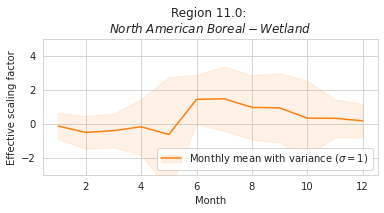

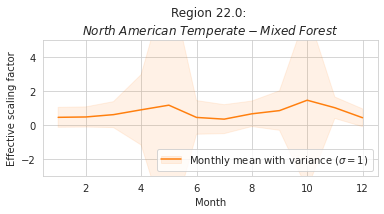

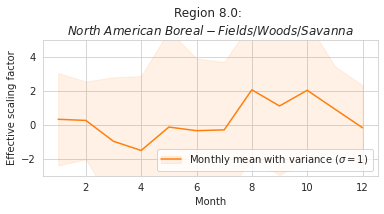

did not find a match in any of xarray's currently installed IO backends ['h5netcdf', 'scipy']. Consider explicitly selecting one of the installed engines via the ``engine`` parameter, or installing additional IO dependencies, see:
https://docs.xarray.dev/en/stable/getting-started-guide/installing.html
https://docs.xarray.dev/en/stable/user-guide/io.html
The loaded file contained an incompatible model. Training a new model
starting training process of monthly model, at eco-region 3.0 using data starting at 2009
did not find a match in any of xarray's currently installed IO backends ['h5netcdf', 'scipy']. Consider explicitly selecting one of the installed engines via the ``engine`` parameter, or installing additional IO dependencies, see:
https://docs.xarray.dev/en/stable/getting-started-guide/installing.html
https://docs.xarray.dev/en/stable/user-guide/io.html
The loaded file contained an incompatible model. Training a new model
starting training process of monthly model, at eco-region 

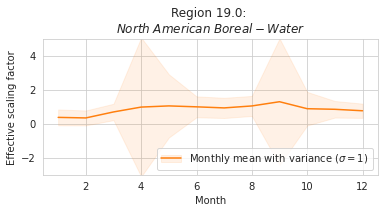

starting training process of monthly model, at eco-region 22.0 using data starting at 2009


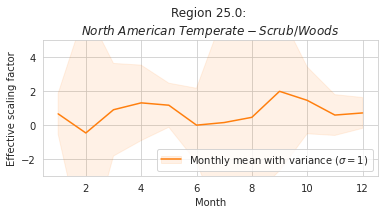

did not find a match in any of xarray's currently installed IO backends ['h5netcdf', 'scipy']. Consider explicitly selecting one of the installed engines via the ``engine`` parameter, or installing additional IO dependencies, see:
https://docs.xarray.dev/en/stable/getting-started-guide/installing.html
https://docs.xarray.dev/en/stable/user-guide/io.html
The loaded file contained an incompatible model. Training a new model
starting training process of monthly model, at eco-region 19.0 using data starting at 2010
did not find a match in any of xarray's currently installed IO backends ['h5netcdf', 'scipy']. Consider explicitly selecting one of the installed engines via the ``engine`` parameter, or installing additional IO dependencies, see:
https://docs.xarray.dev/en/stable/getting-started-guide/installing.html
https://docs.xarray.dev/en/stable/user-guide/io.html
The loaded file contained an incompatible model. Training a new model
starting training process of monthly model, at eco-region

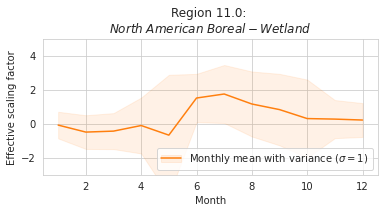

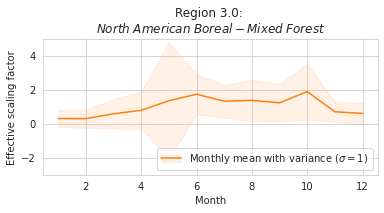

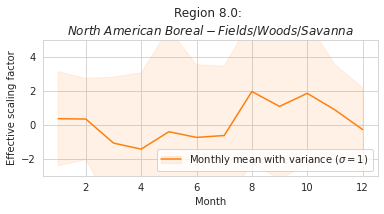

did not find a match in any of xarray's currently installed IO backends ['h5netcdf', 'scipy']. Consider explicitly selecting one of the installed engines via the ``engine`` parameter, or installing additional IO dependencies, see:
https://docs.xarray.dev/en/stable/getting-started-guide/installing.html
https://docs.xarray.dev/en/stable/user-guide/io.html
The loaded file contained an incompatible model. Training a new model
starting training process of monthly model, at eco-region 11.0 using data starting at 2010
did not find a match in any of xarray's currently installed IO backends ['h5netcdf', 'scipy']. Consider explicitly selecting one of the installed engines via the ``engine`` parameter, or installing additional IO dependencies, see:
https://docs.xarray.dev/en/stable/getting-started-guide/installing.html
https://docs.xarray.dev/en/stable/user-guide/io.html
The loaded file contained an incompatible model. Training a new model
starting training process of monthly model, at eco-region

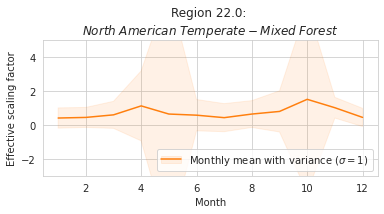

did not find a match in any of xarray's currently installed IO backends ['h5netcdf', 'scipy']. Consider explicitly selecting one of the installed engines via the ``engine`` parameter, or installing additional IO dependencies, see:
https://docs.xarray.dev/en/stable/getting-started-guide/installing.html
https://docs.xarray.dev/en/stable/user-guide/io.html
The loaded file contained an incompatible model. Training a new model
starting training process of monthly model, at eco-region 8.0 using data starting at 2011


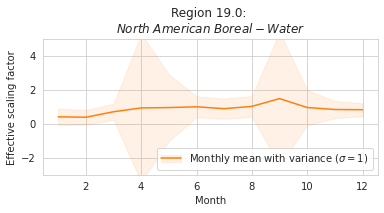

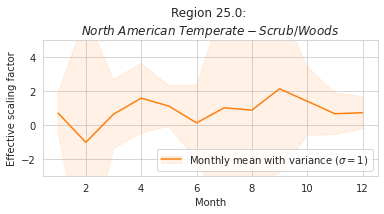

did not find a match in any of xarray's currently installed IO backends ['h5netcdf', 'scipy']. Consider explicitly selecting one of the installed engines via the ``engine`` parameter, or installing additional IO dependencies, see:
https://docs.xarray.dev/en/stable/getting-started-guide/installing.html
https://docs.xarray.dev/en/stable/user-guide/io.html
The loaded file contained an incompatible model. Training a new model
starting training process of monthly model, at eco-region 22.0 using data starting at 2010
did not find a match in any of xarray's currently installed IO backends ['h5netcdf', 'scipy']. Consider explicitly selecting one of the installed engines via the ``engine`` parameter, or installing additional IO dependencies, see:
https://docs.xarray.dev/en/stable/getting-started-guide/installing.html
https://docs.xarray.dev/en/stable/user-guide/io.html
The loaded file contained an incompatible model. Training a new model
starting training process of monthly model, at eco-region

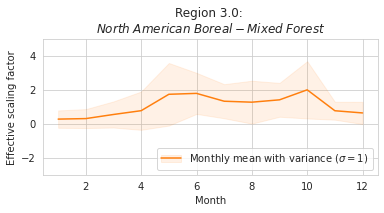

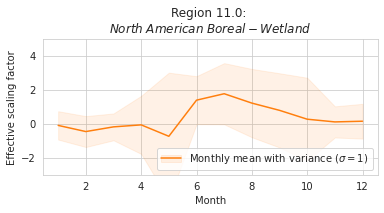

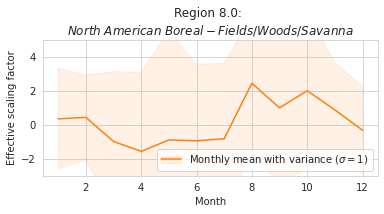

did not find a match in any of xarray's currently installed IO backends ['h5netcdf', 'scipy']. Consider explicitly selecting one of the installed engines via the ``engine`` parameter, or installing additional IO dependencies, see:
https://docs.xarray.dev/en/stable/getting-started-guide/installing.html
https://docs.xarray.dev/en/stable/user-guide/io.html
The loaded file contained an incompatible model. Training a new model
starting training process of monthly model, at eco-region 3.0 using data starting at 2011


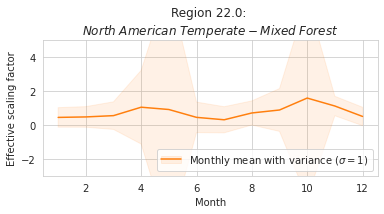

did not find a match in any of xarray's currently installed IO backends ['h5netcdf', 'scipy']. Consider explicitly selecting one of the installed engines via the ``engine`` parameter, or installing additional IO dependencies, see:
https://docs.xarray.dev/en/stable/getting-started-guide/installing.html
https://docs.xarray.dev/en/stable/user-guide/io.html
The loaded file contained an incompatible model. Training a new model
did not find a match in any of xarray's currently installed IO backends ['h5netcdf', 'scipy']. Consider explicitly selecting one of the installed engines via the ``engine`` parameter, or installing additional IO dependencies, see:
https://docs.xarray.dev/en/stable/getting-started-guide/installing.html
https://docs.xarray.dev/en/stable/user-guide/io.html
starting training process of monthly model, at eco-region 8.0 using data starting at 2012
The loaded file contained an incompatible model. Training a new model
starting training process of monthly model, at eco-region 

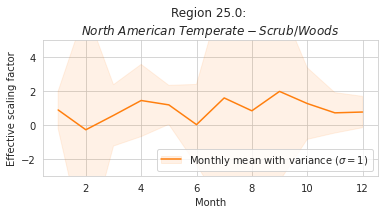

did not find a match in any of xarray's currently installed IO backends ['h5netcdf', 'scipy']. Consider explicitly selecting one of the installed engines via the ``engine`` parameter, or installing additional IO dependencies, see:
https://docs.xarray.dev/en/stable/getting-started-guide/installing.html
https://docs.xarray.dev/en/stable/user-guide/io.html
The loaded file contained an incompatible model. Training a new model


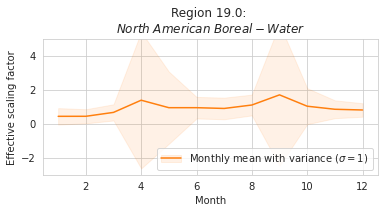

starting training process of monthly model, at eco-region 22.0 using data starting at 2011
did not find a match in any of xarray's currently installed IO backends ['h5netcdf', 'scipy']. Consider explicitly selecting one of the installed engines via the ``engine`` parameter, or installing additional IO dependencies, see:
https://docs.xarray.dev/en/stable/getting-started-guide/installing.html
https://docs.xarray.dev/en/stable/user-guide/io.html
The loaded file contained an incompatible model. Training a new model
starting training process of monthly model, at eco-region 25.0 using data starting at 2012
did not find a match in any of xarray's currently installed IO backends ['h5netcdf', 'scipy']. Consider explicitly selecting one of the installed engines via the ``engine`` parameter, or installing additional IO dependencies, see:
https://docs.xarray.dev/en/stable/getting-started-guide/installing.html
https://docs.xarray.dev/en/stable/user-guide/io.html
The loaded file contained an incompa

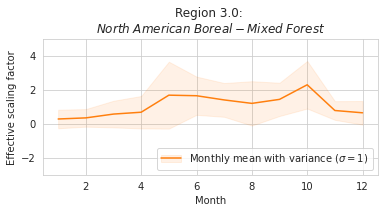

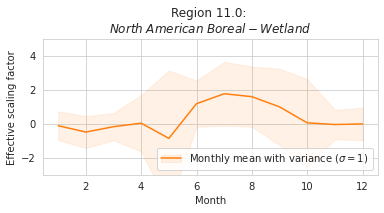

did not find a match in any of xarray's currently installed IO backends ['h5netcdf', 'scipy']. Consider explicitly selecting one of the installed engines via the ``engine`` parameter, or installing additional IO dependencies, see:
https://docs.xarray.dev/en/stable/getting-started-guide/installing.html
https://docs.xarray.dev/en/stable/user-guide/io.html
The loaded file contained an incompatible model. Training a new model
starting training process of monthly model, at eco-region 3.0 using data starting at 2012
did not find a match in any of xarray's currently installed IO backends ['h5netcdf', 'scipy']. Consider explicitly selecting one of the installed engines via the ``engine`` parameter, or installing additional IO dependencies, see:
https://docs.xarray.dev/en/stable/getting-started-guide/installing.html
https://docs.xarray.dev/en/stable/user-guide/io.html
The loaded file contained an incompatible model. Training a new model
starting training process of monthly model, at eco-region 

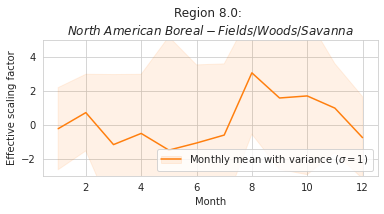

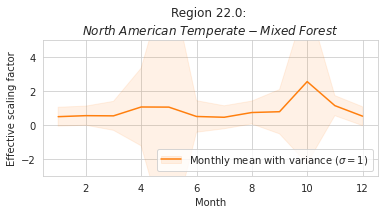

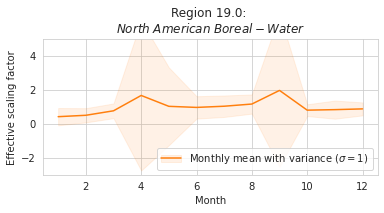

did not find a match in any of xarray's currently installed IO backends ['h5netcdf', 'scipy']. Consider explicitly selecting one of the installed engines via the ``engine`` parameter, or installing additional IO dependencies, see:
https://docs.xarray.dev/en/stable/getting-started-guide/installing.html
https://docs.xarray.dev/en/stable/user-guide/io.htmldid not find a match in any of xarray's currently installed IO backends ['h5netcdf', 'scipy']. Consider explicitly selecting one of the installed engines via the ``engine`` parameter, or installing additional IO dependencies, see:
https://docs.xarray.dev/en/stable/getting-started-guide/installing.html
https://docs.xarray.dev/en/stable/user-guide/io.html

The loaded file contained an incompatible model. Training a new modelThe loaded file contained an incompatible model. Training a new model

starting training process of monthly model, at eco-region 8.0 using data starting at 2013starting training process of monthly model, at eco-region 2

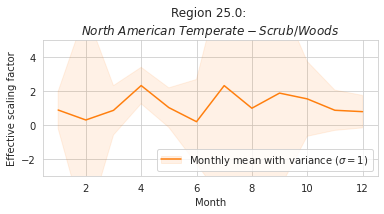

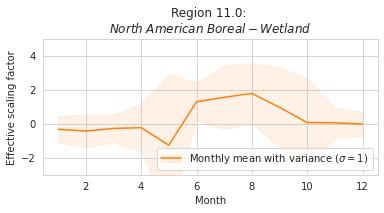

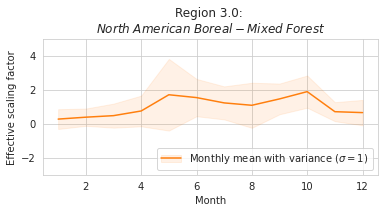

did not find a match in any of xarray's currently installed IO backends ['h5netcdf', 'scipy']. Consider explicitly selecting one of the installed engines via the ``engine`` parameter, or installing additional IO dependencies, see:
https://docs.xarray.dev/en/stable/getting-started-guide/installing.html
https://docs.xarray.dev/en/stable/user-guide/io.html
The loaded file contained an incompatible model. Training a new model
starting training process of monthly model, at eco-region 11.0 using data starting at 2013
did not find a match in any of xarray's currently installed IO backends ['h5netcdf', 'scipy']. Consider explicitly selecting one of the installed engines via the ``engine`` parameter, or installing additional IO dependencies, see:
https://docs.xarray.dev/en/stable/getting-started-guide/installing.html
https://docs.xarray.dev/en/stable/user-guide/io.html
The loaded file contained an incompatible model. Training a new model
starting training process of monthly model, at eco-region

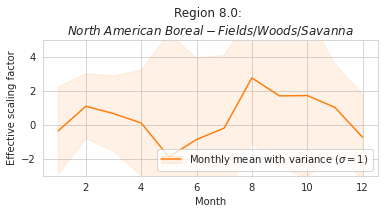

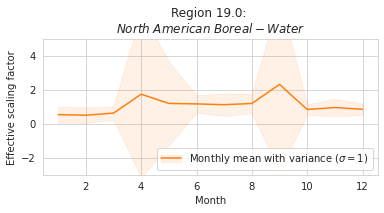

did not find a match in any of xarray's currently installed IO backends ['h5netcdf', 'scipy']. Consider explicitly selecting one of the installed engines via the ``engine`` parameter, or installing additional IO dependencies, see:
https://docs.xarray.dev/en/stable/getting-started-guide/installing.html
https://docs.xarray.dev/en/stable/user-guide/io.html
The loaded file contained an incompatible model. Training a new model


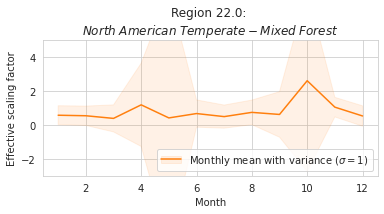

starting training process of monthly model, at eco-region 8.0 using data starting at 2014
did not find a match in any of xarray's currently installed IO backends ['h5netcdf', 'scipy']. Consider explicitly selecting one of the installed engines via the ``engine`` parameter, or installing additional IO dependencies, see:
https://docs.xarray.dev/en/stable/getting-started-guide/installing.html
https://docs.xarray.dev/en/stable/user-guide/io.html
The loaded file contained an incompatible model. Training a new model
starting training process of monthly model, at eco-region 19.0 using data starting at 2014
did not find a match in any of xarray's currently installed IO backends ['h5netcdf', 'scipy']. Consider explicitly selecting one of the installed engines via the ``engine`` parameter, or installing additional IO dependencies, see:
https://docs.xarray.dev/en/stable/getting-started-guide/installing.html
https://docs.xarray.dev/en/stable/user-guide/io.html
The loaded file contained an incompat

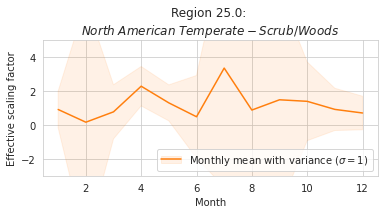

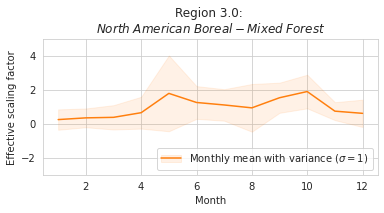

did not find a match in any of xarray's currently installed IO backends ['h5netcdf', 'scipy']. Consider explicitly selecting one of the installed engines via the ``engine`` parameter, or installing additional IO dependencies, see:
https://docs.xarray.dev/en/stable/getting-started-guide/installing.html
https://docs.xarray.dev/en/stable/user-guide/io.html
The loaded file contained an incompatible model. Training a new model
starting training process of monthly model, at eco-region 25.0 using data starting at 2014
did not find a match in any of xarray's currently installed IO backends ['h5netcdf', 'scipy']. Consider explicitly selecting one of the installed engines via the ``engine`` parameter, or installing additional IO dependencies, see:
https://docs.xarray.dev/en/stable/getting-started-guide/installing.html
https://docs.xarray.dev/en/stable/user-guide/io.html
The loaded file contained an incompatible model. Training a new model
starting training process of monthly model, at eco-region

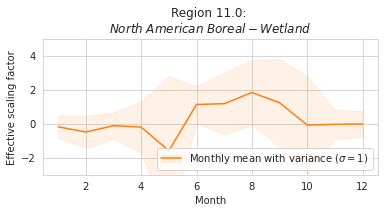

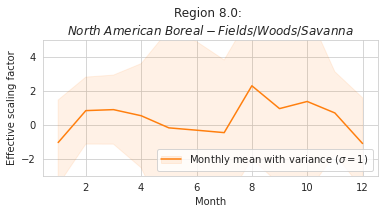

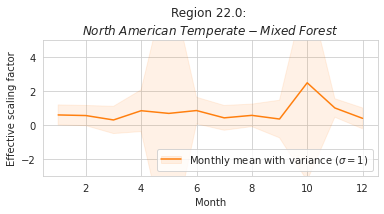

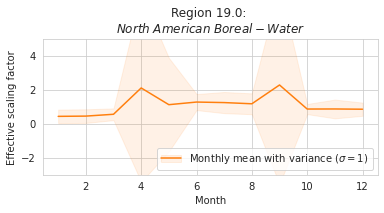

did not find a match in any of xarray's currently installed IO backends ['h5netcdf', 'scipy']. Consider explicitly selecting one of the installed engines via the ``engine`` parameter, or installing additional IO dependencies, see:
https://docs.xarray.dev/en/stable/getting-started-guide/installing.html
https://docs.xarray.dev/en/stable/user-guide/io.html
The loaded file contained an incompatible model. Training a new model
starting training process of monthly model, at eco-region 11.0 using data starting at 2014
did not find a match in any of xarray's currently installed IO backends ['h5netcdf', 'scipy']. Consider explicitly selecting one of the installed engines via the ``engine`` parameter, or installing additional IO dependencies, see:
https://docs.xarray.dev/en/stable/getting-started-guide/installing.html
https://docs.xarray.dev/en/stable/user-guide/io.html
The loaded file contained an incompatible model. Training a new model
starting training process of monthly model, at eco-region

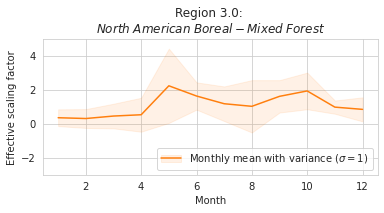

did not find a match in any of xarray's currently installed IO backends ['h5netcdf', 'scipy']. Consider explicitly selecting one of the installed engines via the ``engine`` parameter, or installing additional IO dependencies, see:
https://docs.xarray.dev/en/stable/getting-started-guide/installing.html
https://docs.xarray.dev/en/stable/user-guide/io.html
The loaded file contained an incompatible model. Training a new model
starting training process of monthly model, at eco-region 19.0 using data starting at 2015
did not find a match in any of xarray's currently installed IO backends ['h5netcdf', 'scipy']. Consider explicitly selecting one of the installed engines via the ``engine`` parameter, or installing additional IO dependencies, see:
https://docs.xarray.dev/en/stable/getting-started-guide/installing.html
https://docs.xarray.dev/en/stable/user-guide/io.html
The loaded file contained an incompatible model. Training a new model
starting training process of monthly model, at eco-region

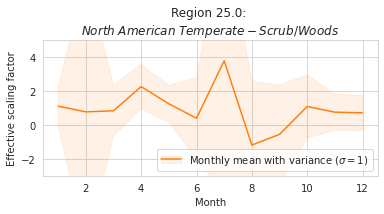

did not find a match in any of xarray's currently installed IO backends ['h5netcdf', 'scipy']. Consider explicitly selecting one of the installed engines via the ``engine`` parameter, or installing additional IO dependencies, see:
https://docs.xarray.dev/en/stable/getting-started-guide/installing.html
https://docs.xarray.dev/en/stable/user-guide/io.html
The loaded file contained an incompatible model. Training a new model
starting training process of monthly model, at eco-region 3.0 using data starting at 2015
did not find a match in any of xarray's currently installed IO backends ['h5netcdf', 'scipy']. Consider explicitly selecting one of the installed engines via the ``engine`` parameter, or installing additional IO dependencies, see:
https://docs.xarray.dev/en/stable/getting-started-guide/installing.html
https://docs.xarray.dev/en/stable/user-guide/io.html
The loaded file contained an incompatible model. Training a new model
starting training process of monthly model, at eco-region 

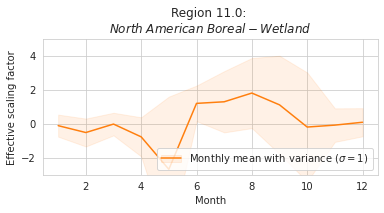

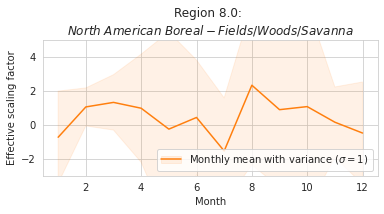

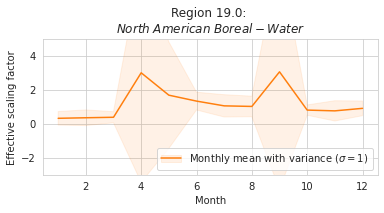

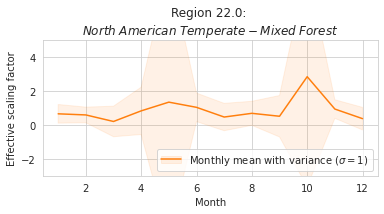

did not find a match in any of xarray's currently installed IO backends ['h5netcdf', 'scipy']. Consider explicitly selecting one of the installed engines via the ``engine`` parameter, or installing additional IO dependencies, see:
https://docs.xarray.dev/en/stable/getting-started-guide/installing.html
https://docs.xarray.dev/en/stable/user-guide/io.html
The loaded file contained an incompatible model. Training a new model
starting training process of monthly model, at eco-region 11.0 using data starting at 2015
did not find a match in any of xarray's currently installed IO backends ['h5netcdf', 'scipy']. Consider explicitly selecting one of the installed engines via the ``engine`` parameter, or installing additional IO dependencies, see:
https://docs.xarray.dev/en/stable/getting-started-guide/installing.html
https://docs.xarray.dev/en/stable/user-guide/io.html
The loaded file contained an incompatible model. Training a new model
starting training process of monthly model, at eco-region

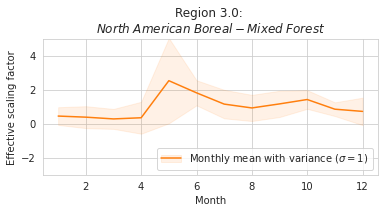

did not find a match in any of xarray's currently installed IO backends ['h5netcdf', 'scipy']. Consider explicitly selecting one of the installed engines via the ``engine`` parameter, or installing additional IO dependencies, see:
https://docs.xarray.dev/en/stable/getting-started-guide/installing.html
https://docs.xarray.dev/en/stable/user-guide/io.html
The loaded file contained an incompatible model. Training a new model
starting training process of monthly model, at eco-region 22.0 using data starting at 2015


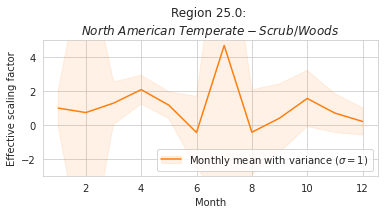

did not find a match in any of xarray's currently installed IO backends ['h5netcdf', 'scipy']. Consider explicitly selecting one of the installed engines via the ``engine`` parameter, or installing additional IO dependencies, see:
https://docs.xarray.dev/en/stable/getting-started-guide/installing.html
https://docs.xarray.dev/en/stable/user-guide/io.html
The loaded file contained an incompatible model. Training a new model
starting training process of monthly model, at eco-region 3.0 using data starting at 2016


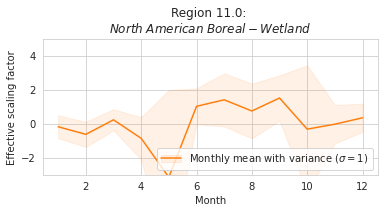

did not find a match in any of xarray's currently installed IO backends ['h5netcdf', 'scipy']. Consider explicitly selecting one of the installed engines via the ``engine`` parameter, or installing additional IO dependencies, see:
https://docs.xarray.dev/en/stable/getting-started-guide/installing.html
https://docs.xarray.dev/en/stable/user-guide/io.html
The loaded file contained an incompatible model. Training a new model
starting training process of monthly model, at eco-region 25.0 using data starting at 2016
did not find a match in any of xarray's currently installed IO backends ['h5netcdf', 'scipy']. Consider explicitly selecting one of the installed engines via the ``engine`` parameter, or installing additional IO dependencies, see:
https://docs.xarray.dev/en/stable/getting-started-guide/installing.html
https://docs.xarray.dev/en/stable/user-guide/io.html
The loaded file contained an incompatible model. Training a new model
starting training process of monthly model, at eco-region

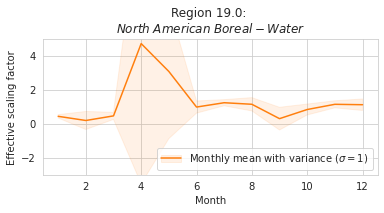

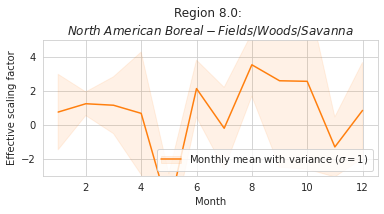

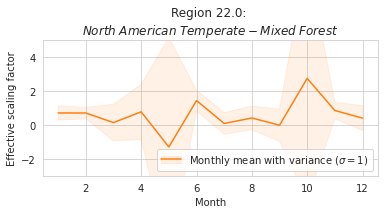

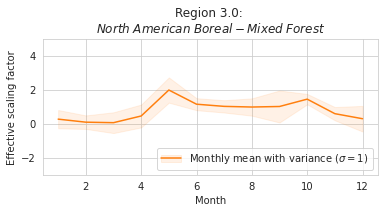

writing intermediate results for region 19.0
writing intermediate results for region 8.0
did not find a match in any of xarray's currently installed IO backends ['h5netcdf', 'scipy']. Consider explicitly selecting one of the installed engines via the ``engine`` parameter, or installing additional IO dependencies, see:
https://docs.xarray.dev/en/stable/getting-started-guide/installing.html
https://docs.xarray.dev/en/stable/user-guide/io.html
The loaded file contained an incompatible model. Training a new model
starting training process of monthly model, at eco-region 22.0 using data starting at 2016


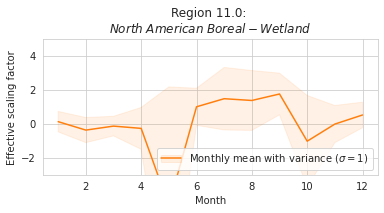

writing intermediate results for region 3.0


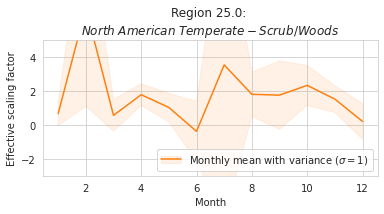

Finished writing results for region 19.0Finished writing results for region 8.0
Determining sf prediction of region 9.0
Determining sf prediction of region 20.0

No sf data exists on region 20.0. Making new sf prediction
No sf data exists on region 9.0. Making new sf predictionwriting intermediate results for region 11.0

did not find a match in any of xarray's currently installed IO backends ['h5netcdf', 'scipy']. Consider explicitly selecting one of the installed engines via the ``engine`` parameter, or installing additional IO dependencies, see:
https://docs.xarray.dev/en/stable/getting-started-guide/installing.html
https://docs.xarray.dev/en/stable/user-guide/io.html
The loaded file contained an incompatible model. Training a new model
did not find a match in any of xarray's currently installed IO backends ['h5netcdf', 'scipy']. Consider explicitly selecting one of the installed engines via the ``engine`` parameter, or installing additional IO dependencies, see:
https://docs.xarray

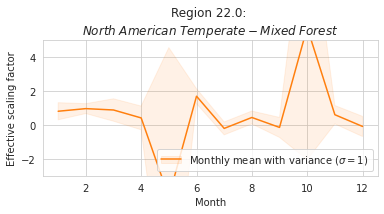

Finished writing results for region 11.0
Determining sf prediction of region 15.0
No sf data exists on region 15.0. Making new sf prediction
did not find a match in any of xarray's currently installed IO backends ['h5netcdf', 'scipy']. Consider explicitly selecting one of the installed engines via the ``engine`` parameter, or installing additional IO dependencies, see:
https://docs.xarray.dev/en/stable/getting-started-guide/installing.html
https://docs.xarray.dev/en/stable/user-guide/io.html
The loaded file contained an incompatible model. Training a new model
starting training process of monthly model, at eco-region 15.0 using data starting at 2000
Finished writing results for region 25.0
Determining sf prediction of region 26.0
No sf data exists on region 26.0. Making new sf prediction
did not find a match in any of xarray's currently installed IO backends ['h5netcdf', 'scipy']. Consider explicitly selecting one of the installed engines via the ``engine`` parameter, or installing add

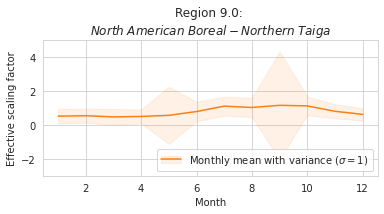

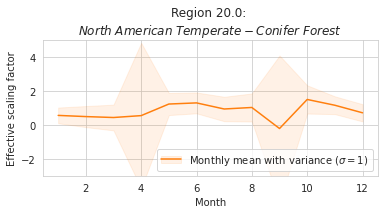

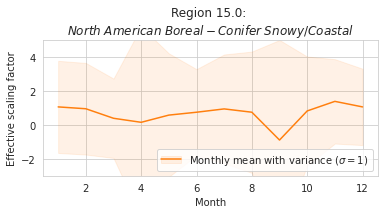

did not find a match in any of xarray's currently installed IO backends ['h5netcdf', 'scipy']. Consider explicitly selecting one of the installed engines via the ``engine`` parameter, or installing additional IO dependencies, see:
https://docs.xarray.dev/en/stable/getting-started-guide/installing.html
https://docs.xarray.dev/en/stable/user-guide/io.html
The loaded file contained an incompatible model. Training a new model
starting training process of monthly model, at eco-region 9.0 using data starting at 2001
did not find a match in any of xarray's currently installed IO backends ['h5netcdf', 'scipy']. Consider explicitly selecting one of the installed engines via the ``engine`` parameter, or installing additional IO dependencies, see:
https://docs.xarray.dev/en/stable/getting-started-guide/installing.html
https://docs.xarray.dev/en/stable/user-guide/io.html
The loaded file contained an incompatible model. Training a new model
starting training process of monthly model, at eco-region 

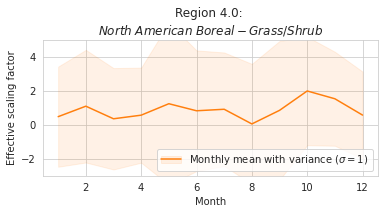

did not find a match in any of xarray's currently installed IO backends ['h5netcdf', 'scipy']. Consider explicitly selecting one of the installed engines via the ``engine`` parameter, or installing additional IO dependencies, see:
https://docs.xarray.dev/en/stable/getting-started-guide/installing.html
https://docs.xarray.dev/en/stable/user-guide/io.html
The loaded file contained an incompatible model. Training a new model
starting training process of monthly model, at eco-region 15.0 using data starting at 2001


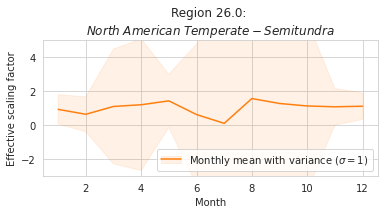

did not find a match in any of xarray's currently installed IO backends ['h5netcdf', 'scipy']. Consider explicitly selecting one of the installed engines via the ``engine`` parameter, or installing additional IO dependencies, see:
https://docs.xarray.dev/en/stable/getting-started-guide/installing.html
https://docs.xarray.dev/en/stable/user-guide/io.html
The loaded file contained an incompatible model. Training a new model
starting training process of monthly model, at eco-region 4.0 using data starting at 2001


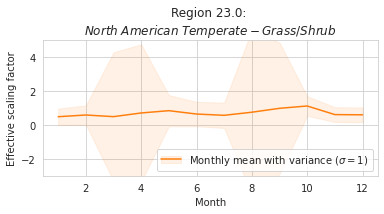

did not find a match in any of xarray's currently installed IO backends ['h5netcdf', 'scipy']. Consider explicitly selecting one of the installed engines via the ``engine`` parameter, or installing additional IO dependencies, see:
https://docs.xarray.dev/en/stable/getting-started-guide/installing.html
https://docs.xarray.dev/en/stable/user-guide/io.html
The loaded file contained an incompatible model. Training a new model
starting training process of monthly model, at eco-region 26.0 using data starting at 2001
did not find a match in any of xarray's currently installed IO backends ['h5netcdf', 'scipy']. Consider explicitly selecting one of the installed engines via the ``engine`` parameter, or installing additional IO dependencies, see:
https://docs.xarray.dev/en/stable/getting-started-guide/installing.html
https://docs.xarray.dev/en/stable/user-guide/io.html
The loaded file contained an incompatible model. Training a new model
starting training process of monthly model, at eco-region

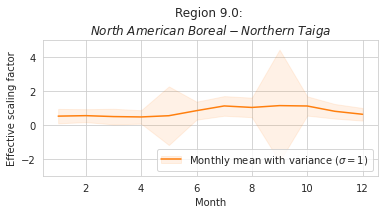

did not find a match in any of xarray's currently installed IO backends ['h5netcdf', 'scipy']. Consider explicitly selecting one of the installed engines via the ``engine`` parameter, or installing additional IO dependencies, see:
https://docs.xarray.dev/en/stable/getting-started-guide/installing.html
https://docs.xarray.dev/en/stable/user-guide/io.html


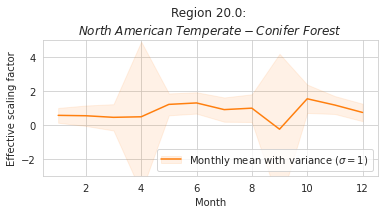

The loaded file contained an incompatible model. Training a new model
starting training process of monthly model, at eco-region 9.0 using data starting at 2002


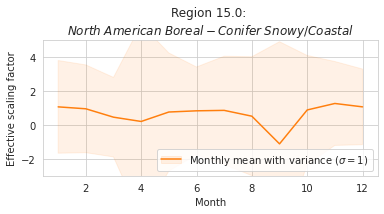

did not find a match in any of xarray's currently installed IO backends ['h5netcdf', 'scipy']. Consider explicitly selecting one of the installed engines via the ``engine`` parameter, or installing additional IO dependencies, see:
https://docs.xarray.dev/en/stable/getting-started-guide/installing.html
https://docs.xarray.dev/en/stable/user-guide/io.html
The loaded file contained an incompatible model. Training a new model
starting training process of monthly model, at eco-region 20.0 using data starting at 2002


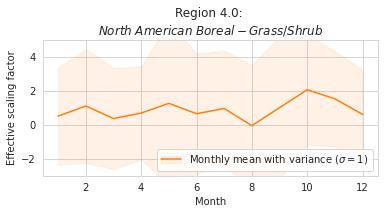

did not find a match in any of xarray's currently installed IO backends ['h5netcdf', 'scipy']. Consider explicitly selecting one of the installed engines via the ``engine`` parameter, or installing additional IO dependencies, see:
https://docs.xarray.dev/en/stable/getting-started-guide/installing.html
https://docs.xarray.dev/en/stable/user-guide/io.html
The loaded file contained an incompatible model. Training a new model
starting training process of monthly model, at eco-region 15.0 using data starting at 2002


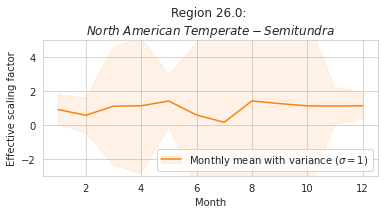

did not find a match in any of xarray's currently installed IO backends ['h5netcdf', 'scipy']. Consider explicitly selecting one of the installed engines via the ``engine`` parameter, or installing additional IO dependencies, see:
https://docs.xarray.dev/en/stable/getting-started-guide/installing.html
https://docs.xarray.dev/en/stable/user-guide/io.html
The loaded file contained an incompatible model. Training a new model
starting training process of monthly model, at eco-region 4.0 using data starting at 2002
did not find a match in any of xarray's currently installed IO backends ['h5netcdf', 'scipy']. Consider explicitly selecting one of the installed engines via the ``engine`` parameter, or installing additional IO dependencies, see:
https://docs.xarray.dev/en/stable/getting-started-guide/installing.html
https://docs.xarray.dev/en/stable/user-guide/io.html
The loaded file contained an incompatible model. Training a new model
starting training process of monthly model, at eco-region 

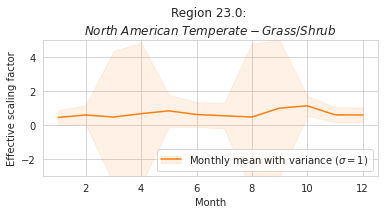

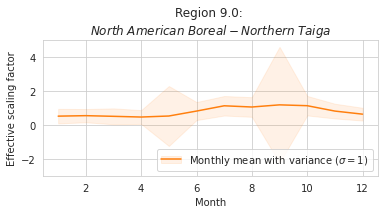

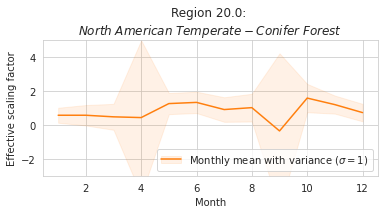

did not find a match in any of xarray's currently installed IO backends ['h5netcdf', 'scipy']. Consider explicitly selecting one of the installed engines via the ``engine`` parameter, or installing additional IO dependencies, see:
https://docs.xarray.dev/en/stable/getting-started-guide/installing.html
https://docs.xarray.dev/en/stable/user-guide/io.html
The loaded file contained an incompatible model. Training a new model
starting training process of monthly model, at eco-region 23.0 using data starting at 2002


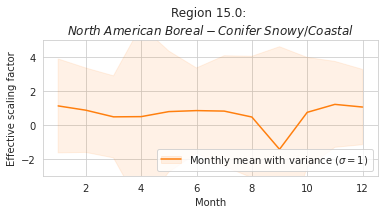

did not find a match in any of xarray's currently installed IO backends ['h5netcdf', 'scipy']. Consider explicitly selecting one of the installed engines via the ``engine`` parameter, or installing additional IO dependencies, see:
https://docs.xarray.dev/en/stable/getting-started-guide/installing.html
https://docs.xarray.dev/en/stable/user-guide/io.html
The loaded file contained an incompatible model. Training a new model
starting training process of monthly model, at eco-region 9.0 using data starting at 2003
did not find a match in any of xarray's currently installed IO backends ['h5netcdf', 'scipy']. Consider explicitly selecting one of the installed engines via the ``engine`` parameter, or installing additional IO dependencies, see:
https://docs.xarray.dev/en/stable/getting-started-guide/installing.html
https://docs.xarray.dev/en/stable/user-guide/io.html
The loaded file contained an incompatible model. Training a new model
starting training process of monthly model, at eco-region 

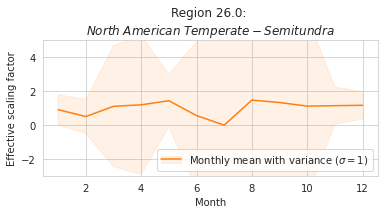

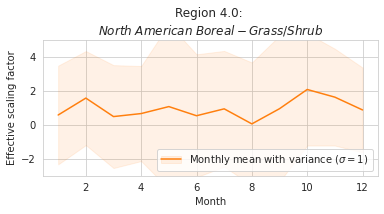

did not find a match in any of xarray's currently installed IO backends ['h5netcdf', 'scipy']. Consider explicitly selecting one of the installed engines via the ``engine`` parameter, or installing additional IO dependencies, see:
https://docs.xarray.dev/en/stable/getting-started-guide/installing.html
https://docs.xarray.dev/en/stable/user-guide/io.html
The loaded file contained an incompatible model. Training a new model
starting training process of monthly model, at eco-region 26.0 using data starting at 2003


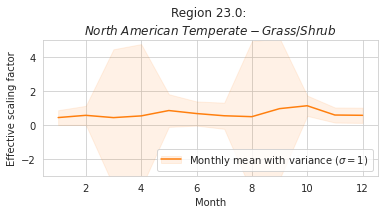

did not find a match in any of xarray's currently installed IO backends ['h5netcdf', 'scipy']. Consider explicitly selecting one of the installed engines via the ``engine`` parameter, or installing additional IO dependencies, see:
https://docs.xarray.dev/en/stable/getting-started-guide/installing.html
https://docs.xarray.dev/en/stable/user-guide/io.html
The loaded file contained an incompatible model. Training a new model
starting training process of monthly model, at eco-region 4.0 using data starting at 2003
did not find a match in any of xarray's currently installed IO backends ['h5netcdf', 'scipy']. Consider explicitly selecting one of the installed engines via the ``engine`` parameter, or installing additional IO dependencies, see:
https://docs.xarray.dev/en/stable/getting-started-guide/installing.html
https://docs.xarray.dev/en/stable/user-guide/io.html
The loaded file contained an incompatible model. Training a new model
starting training process of monthly model, at eco-region 

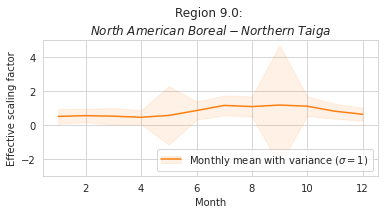

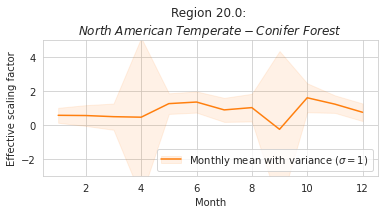

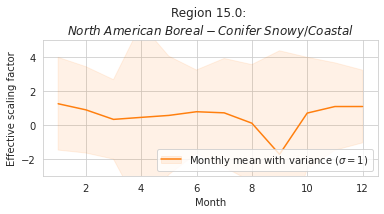

did not find a match in any of xarray's currently installed IO backends ['h5netcdf', 'scipy']. Consider explicitly selecting one of the installed engines via the ``engine`` parameter, or installing additional IO dependencies, see:
https://docs.xarray.dev/en/stable/getting-started-guide/installing.html
https://docs.xarray.dev/en/stable/user-guide/io.html
The loaded file contained an incompatible model. Training a new model
starting training process of monthly model, at eco-region 9.0 using data starting at 2004
did not find a match in any of xarray's currently installed IO backends ['h5netcdf', 'scipy']. Consider explicitly selecting one of the installed engines via the ``engine`` parameter, or installing additional IO dependencies, see:
https://docs.xarray.dev/en/stable/getting-started-guide/installing.html
https://docs.xarray.dev/en/stable/user-guide/io.html
The loaded file contained an incompatible model. Training a new model
starting training process of monthly model, at eco-region 

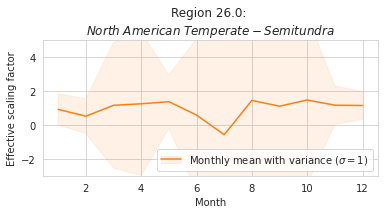

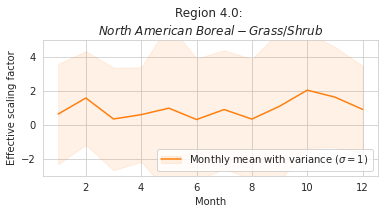

did not find a match in any of xarray's currently installed IO backends ['h5netcdf', 'scipy']. Consider explicitly selecting one of the installed engines via the ``engine`` parameter, or installing additional IO dependencies, see:
https://docs.xarray.dev/en/stable/getting-started-guide/installing.html
https://docs.xarray.dev/en/stable/user-guide/io.htmldid not find a match in any of xarray's currently installed IO backends ['h5netcdf', 'scipy']. Consider explicitly selecting one of the installed engines via the ``engine`` parameter, or installing additional IO dependencies, see:
https://docs.xarray.dev/en/stable/getting-started-guide/installing.html
https://docs.xarray.dev/en/stable/user-guide/io.html

The loaded file contained an incompatible model. Training a new model
starting training process of monthly model, at eco-region 4.0 using data starting at 2004
The loaded file contained an incompatible model. Training a new model
starting training process of monthly model, at eco-region 

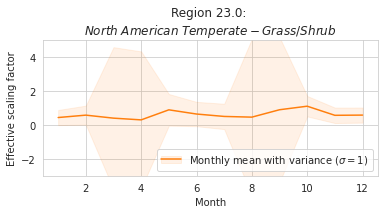

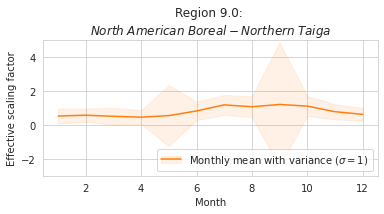

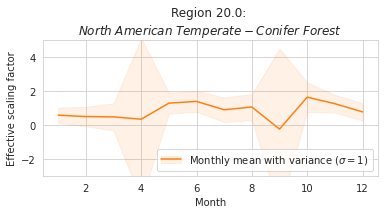

did not find a match in any of xarray's currently installed IO backends ['h5netcdf', 'scipy']. Consider explicitly selecting one of the installed engines via the ``engine`` parameter, or installing additional IO dependencies, see:
https://docs.xarray.dev/en/stable/getting-started-guide/installing.html
https://docs.xarray.dev/en/stable/user-guide/io.html
The loaded file contained an incompatible model. Training a new model
starting training process of monthly model, at eco-region 23.0 using data starting at 2004


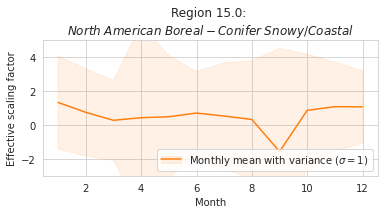

did not find a match in any of xarray's currently installed IO backends ['h5netcdf', 'scipy']. Consider explicitly selecting one of the installed engines via the ``engine`` parameter, or installing additional IO dependencies, see:
https://docs.xarray.dev/en/stable/getting-started-guide/installing.html
https://docs.xarray.dev/en/stable/user-guide/io.html
The loaded file contained an incompatible model. Training a new model
starting training process of monthly model, at eco-region 9.0 using data starting at 2005
did not find a match in any of xarray's currently installed IO backends ['h5netcdf', 'scipy']. Consider explicitly selecting one of the installed engines via the ``engine`` parameter, or installing additional IO dependencies, see:
https://docs.xarray.dev/en/stable/getting-started-guide/installing.html
https://docs.xarray.dev/en/stable/user-guide/io.html
The loaded file contained an incompatible model. Training a new model
starting training process of monthly model, at eco-region 

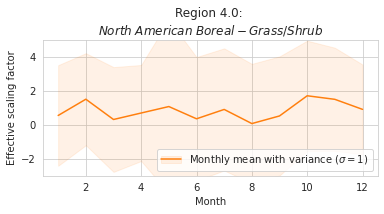

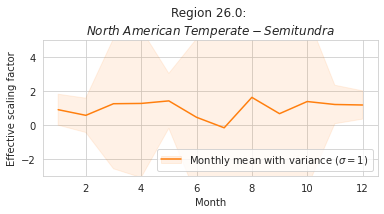

Process ForkPoolWorker-5:
Process ForkPoolWorker-2:
Process ForkPoolWorker-1:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/user/.pyenv/versions/MasterProject-3.9.2/lib/python3.9/site-packages/xarray/backends/file_manager.py", line 201, in _acquire_with_cache_info
    file = self._cache[self._key]
  File "/home/user/.pyenv/versions/MasterProject-3.9.2/lib/python3.9/site-packages/xarray/backends/lru_cache.py", line 55, in __getitem__
    value = self._cache[key]
Traceback (most recent call last):
  File "/home/user/.pyenv/versions/MasterProject-3.9.2/lib/python3.9/site-packages/xarray/backends/file_manager.py", line 201, in _acquire_with_cache_info
    file = self._cache[self._key]
KeyError: [<class 'h5netcdf.core.File'>, ('/home/user/Documents/RUG/Master/Master Project/MasterProject/fitted_sf/monthly/monthly_9.0.nc',), 'r', (('decode_vlen_strings', True), ('invalid_netcdf', None))]
  File "/home/user/.pyenv/versions/MasterProject-3.9.2/lib/python3.

KeyboardInterrupt: 

In [2]:
import timeit

start_time = timeit.default_timer()


model = monthly_model(machine='local', show_fit=True)
sf_ds = model.run_model(data_file='vars_per_eco_update.nc')

# print(sf_ds)
# sf_file = monthly_model.SF_DIR + 'monthly_sf.nc'
#
# with xr.open_dataset(sf_file) as ds:
#     sf_ds = ds

# tc_results = monthly_model.test_model(sf_ds, per_tc_region=True)
# print(tc_results)

# tc_results_file = monthly_model.RESULTS_DIR + 'monthly_results_per_tc.pkl'
# tc_results.to_pickle(tc_results_file)

# res_df = monthly_model.test_model(sf_ds)
# results_file = monthly_model.RESULTS_DIR + 'monthly_results.pkl'
# print(res_df)
# res_df.to_pickle(results_file)


stop_time = timeit.default_timer()

print(f'Elapsed time: {stop_time-start_time}')


In [3]:
tc_results

start_year  N_train_years  N_train_obs  N_test_years  N_test_obs  \
1.0         2016              1           53             4         208   
1.0         2015              2          105             4         208   
1.0         2014              3          157             4         208   
1.0         2013              4          209             4         208   
1.0         2012              5          261             4         208   
...          ...            ...          ...           ...         ...   
11.0        2004             13          679             4         208   
11.0        2003             14          731             4         208   
11.0        2002             15          783             4         208   
11.0        2001             16          835             4         208   
11.0        2000             17          888             4         208   

      tc_region  sf_ME_train  sf_MAE_train  sf_MAPE_train  sf_RMSE_train  ...  \
1.0         1.0    -0.025121      0.344484      45.101270       0.727245  ...   
1.0         1.0     0.059783      0.300243      68.113071       0.650412  ...   
1.0         1.0    -0.048271      0.310247      49.420720       0.902498  ...   
1.0         1.0     0.031819      0.345856      47.160241       1.036895  ...   
1.0         1.0     0.022120      0.312047      44.238004       0.736355  ...   
...         ...          ...           ...            ...            ...  ...   
11.0       11.0     0.051707      0.261758      45.101601       0.627208  ...   
11.0       11.0     0.045118      0.265185      42.988008       0.648986  ...   
11.0       11.0     0.039875      0.262742      41.566041       0.645965  ...   
11.0       11.0     0.035658      0.259798      40.563264       0.633766  ...   
11.0       11.0     0.032181      0.257361      41.164818       0.621440  ...   

      sf_ME_test  sf_MAE_test  sf_MAPE_test  sf_RMSE_test  sf_r2_test  \
1.0     0.104559     0.313649     73.240030      0.520299   -0.329647   
1.0     0.066041     0.333080     56.424862      0.858433   -2.619454   
1.0     0.026641     0.281118     49.345511      0.600220   -0.769500   
1.0     0.063738     0.257726     43.825844      0.460710   -0.042523   
1.0     0.053638     0.236649     43.616483      0.350306    0.397268   
...          ...          ...           ...           ...         ...   
11.0    0.061530     0.261259     25.450304      0.564880    0.180297   
11.0    0.069354     0.258993     24.937388      0.556068    0.205672   
11.0    0.062501     0.258097     24.785709      0.564767    0.180625   
11.0    0.059708     0.262893     25.252646      0.584552    0.122209   
11.0    0.065262     0.262803     25.157976      0.578549    0.140146   

      flux_ME_test  flux_MAE_test  flux_MAPE_test  flux_RMSE_test  \
1.0   1.042881e+06    1224289.250       73.240030     1879605.625   
1.0   1.186423e+06    1117301.500       56.424856     1696542.875   
1.0   1.435272e+06    1058537.875       49.345508     1606600.250   
1.0   1.264255e+06    1033799.625       43.825844     1524379.000   
1.0   1.203965e+06    1043601.250       43.616486     1552357.875   
...            ...            ...             ...             ...   
11.0  3.291140e+05    1689548.250       25.450304     2699374.000   
11.0  2.567074e+05    1702046.000       24.937388     2758920.250   
11.0  2.756879e+05    1702497.500       24.785709     2762403.250   
11.0  3.329346e+05    1701082.750       25.252646     2752403.250   
11.0  3.476902e+05    1713103.750       25.157976     2768530.500   

      flux_r2_test  
1.0       0.894133  
1.0       0.913751  
1.0       0.922653  
1.0       0.930368  
1.0       0.927788  
...            ...  
11.0      0.955029  
11.0      0.953023  
11.0      0.952904  
11.0      0.953245  
11.0      0.952695  

[85 rows x 26 columns]

In [3]:
import timeit

start_time = timeit.default_timer()


SARIMAX_params = {'order': (2,0,2),            # Defining the regular AR, I and MA dependencies
                 'seasonal_order': (1,0,1,52), # Defining the seasonal dependencies
                 'trend': 'c',                 # Adding an intercept term
                 'exogenous_vars': ['t2m_AVG'] # Defining the exogenous variables used by SARIMAX
                 }

model = SARIMAX_model(machine='local', **SARIMAX_params)
sf_ds = model.run_model(data_file='vars_per_eco_monthly_anomaly.nc', debug=False)

print(sf_ds)
# sf_file = monthly_model.SF_DIR + 'SARIMA_sf.nc'
#
# with xr.open_dataset(sf_file) as ds:
#     sf_ds = ds

tc_results = model.test_model(sf_ds, per_tc_region=True)
# print(tc_results)

tc_results_file = model.RESULTS_DIR + 'SARIMAX_results_per_tc.pkl'
tc_results.to_pickle(tc_results_file)

res_df = model.test_model(sf_ds)
results_file = model.RESULTS_DIR + 'SARIMAX_results.pkl'
# print(res_df)
res_df.to_pickle(results_file)


stop_time = timeit.default_timer()

print(f'Elapsed time: {stop_time-start_time}')

Determining sf prediction of region 1.0
Determining sf prediction of region 3.0
Determining sf prediction of region 4.0
Determining sf prediction of region 7.0
Determining sf prediction of region 9.0
No sf data exists on region 9.0. Making new sf prediction
Determining sf prediction of region 8.0

No sf data exists on region 8.0. Making new sf predictionDetermining sf prediction of region 19.0
Determining sf prediction of region 24.0No sf data exists on region 19.0. Making new sf prediction

No sf data exists on region 24.0. Making new sf prediction
finished loading model ./trained_models/SARIMAX/2000/SARIMAX_9.0.pkl
finished loading model ./trained_models/SARIMAX/2000/SARIMAX_24.0.pkl
finished loading model ./trained_models/SARIMAX/2000/SARIMAX_19.0.pkl
finished loading model ./trained_models/SARIMAX/2000/SARIMAX_8.0.pkl
finished loading model ./trained_models/SARIMAX/2001/SARIMAX_24.0.pkl
finished loading model ./trained_models/SARIMAX/2001/SARIMAX_9.0.pkl
finished loading model ./tr

/home/user/.pyenv/versions/MasterProject-3.9.2/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


finished loading model ./trained_models/SARIMAX/2007/SARIMAX_11.0.pkl
finished loading model ./trained_models/SARIMAX/2007/SARIMAX_26.0.pkl
finished loading model ./trained_models/SARIMAX/2007/SARIMAX_21.0.pkl
finished loading model ./trained_models/SARIMAX/2008/SARIMAX_11.0.pkl
finished loading model ./trained_models/SARIMAX/2008/SARIMAX_26.0.pkl
finished loading model ./trained_models/SARIMAX/2008/SARIMAX_21.0.pkl
finished loading model ./trained_models/SARIMAX/2009/SARIMAX_11.0.pkl
finished loading model ./trained_models/SARIMAX/2009/SARIMAX_26.0.pkl
finished loading model ./trained_models/SARIMAX/2009/SARIMAX_21.0.pkl
finished loading model ./trained_models/SARIMAX/2010/SARIMAX_11.0.pkl
finished loading model ./trained_models/SARIMAX/2010/SARIMAX_26.0.pkl
finished loading model ./trained_models/SARIMAX/2011/SARIMAX_11.0.pkl
finished loading model ./trained_models/SARIMAX/2010/SARIMAX_21.0.pkl
finished loading model ./trained_models/SARIMAX/2012/SARIMAX_11.0.pkl
finished loading mod

/home/user/.pyenv/versions/MasterProject-3.9.2/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/user/.pyenv/versions/MasterProject-3.9.2/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


finished loading model ./trained_models/SARIMAX/2008/SARIMAX_15.0.pkl
finished loading model ./trained_models/SARIMAX/2008/SARIMAX_27.0.pkl
finished loading model ./trained_models/SARIMAX/2009/SARIMAX_22.0.pkl
finished loading model ./trained_models/SARIMAX/2009/SARIMAX_15.0.pkl
finished loading model ./trained_models/SARIMAX/2009/SARIMAX_27.0.pkl
finished loading model ./trained_models/SARIMAX/2010/SARIMAX_22.0.pkl
finished loading model ./trained_models/SARIMAX/2010/SARIMAX_27.0.pkl
finished loading model ./trained_models/SARIMAX/2011/SARIMAX_22.0.pkl
finished loading model ./trained_models/SARIMAX/2010/SARIMAX_15.0.pkl
finished loading model ./trained_models/SARIMAX/2012/SARIMAX_22.0.pkl
finished loading model ./trained_models/SARIMAX/2011/SARIMAX_27.0.pkl
finished loading model ./trained_models/SARIMAX/2011/SARIMAX_15.0.pkl
finished loading model ./trained_models/SARIMAX/2013/SARIMAX_22.0.pkl
finished loading model ./trained_models/SARIMAX/2012/SARIMAX_27.0.pkl
finished loading mod

/home/user/.pyenv/versions/MasterProject-3.9.2/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/user/.pyenv/versions/MasterProject-3.9.2/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


finished loading model ./trained_models/SARIMAX/2010/SARIMAX_23.0.pkl
finished loading model ./trained_models/SARIMAX/2008/SARIMAX_16.0.pkl
finished loading model ./trained_models/SARIMAX/2009/SARIMAX_29.0.pkl
finished loading model ./trained_models/SARIMAX/2011/SARIMAX_23.0.pkl
finished loading model ./trained_models/SARIMAX/2009/SARIMAX_16.0.pkl
finished loading model ./trained_models/SARIMAX/2010/SARIMAX_29.0.pkl
finished loading model ./trained_models/SARIMAX/2012/SARIMAX_23.0.pkl
finished loading model ./trained_models/SARIMAX/2010/SARIMAX_16.0.pkl
finished loading model ./trained_models/SARIMAX/2013/SARIMAX_23.0.pkl
finished loading model ./trained_models/SARIMAX/2011/SARIMAX_29.0.pkl
finished loading model ./trained_models/SARIMAX/2014/SARIMAX_23.0.pkl
finished loading model ./trained_models/SARIMAX/2011/SARIMAX_16.0.pkl
finished loading model ./trained_models/SARIMAX/2012/SARIMAX_29.0.pkl
finished loading model ./trained_models/SARIMAX/2015/SARIMAX_23.0.pkl
finished loading mod

/home/user/.pyenv/versions/MasterProject-3.9.2/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


finished loading model ./trained_models/SARIMAX/2004/SARIMAX_130.0.pkl
finished loading model ./trained_models/SARIMAX/2005/SARIMAX_115.0.pkl
No file exists, or the existing file is empty. Training new model
starting training process of SARIMAX model, at eco-region 31.0 using data starting at 2011
finished loading model ./trained_models/SARIMAX/2004/SARIMAX_122.0.pkl
finished loading model ./trained_models/SARIMAX/2005/SARIMAX_130.0.pkl
finished loading model ./trained_models/SARIMAX/2006/SARIMAX_115.0.pkl
finished loading model ./trained_models/SARIMAX/2005/SARIMAX_122.0.pkl
finished loading model ./trained_models/SARIMAX/2006/SARIMAX_130.0.pkl
finished loading model ./trained_models/SARIMAX/2007/SARIMAX_115.0.pkl
finished loading model ./trained_models/SARIMAX/2006/SARIMAX_122.0.pkl
finished loading model ./trained_models/SARIMAX/2008/SARIMAX_115.0.pklfinished loading model ./trained_models/SARIMAX/2007/SARIMAX_130.0.pkl

finished loading model ./trained_models/SARIMAX/2007/SARIMAX_1

/home/user/.pyenv/versions/MasterProject-3.9.2/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


finished loading model ./trained_models/SARIMAX/2004/SARIMAX_146.0.pkl
finished loading model ./trained_models/SARIMAX/2007/SARIMAX_135.0.pkl
finished loading model ./trained_models/SARIMAX/2006/SARIMAX_140.0.pkl
finished loading model ./trained_models/SARIMAX/2005/SARIMAX_146.0.pkl
finished loading model ./trained_models/SARIMAX/2008/SARIMAX_135.0.pkl
finished loading model ./trained_models/SARIMAX/2007/SARIMAX_140.0.pkl
finished loading model ./trained_models/SARIMAX/2006/SARIMAX_146.0.pkl
finished loading model ./trained_models/SARIMAX/2009/SARIMAX_135.0.pkl
finished loading model ./trained_models/SARIMAX/2008/SARIMAX_140.0.pkl
finished loading model ./trained_models/SARIMAX/2007/SARIMAX_146.0.pkl
finished loading model ./trained_models/SARIMAX/2010/SARIMAX_135.0.pkl
finished loading model ./trained_models/SARIMAX/2009/SARIMAX_140.0.pkl
finished loading model ./trained_models/SARIMAX/2008/SARIMAX_146.0.pkl
finished loading model ./trained_models/SARIMAX/2011/SARIMAX_135.0.pkl
finish

/home/user/.pyenv/versions/MasterProject-3.9.2/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


finished loading model ./trained_models/SARIMAX/2014/SARIMAX_135.0.pkl
finished loading model ./trained_models/SARIMAX/2010/SARIMAX_146.0.pkl
finished loading model ./trained_models/SARIMAX/2015/SARIMAX_135.0.pkl
finished loading model ./trained_models/SARIMAX/2013/SARIMAX_140.0.pkl
finished loading model ./trained_models/SARIMAX/2016/SARIMAX_135.0.pkl
writing intermediate results for region 135.0
finished loading model ./trained_models/SARIMAX/2014/SARIMAX_140.0.pkl
finished loading model ./trained_models/SARIMAX/2011/SARIMAX_146.0.pkl
Finished writing results for region 135.0
Determining sf prediction of region 136.0
No sf data exists on region 136.0. Making new sf prediction
finished loading model ./trained_models/SARIMAX/2015/SARIMAX_140.0.pkl
finished loading model ./trained_models/SARIMAX/2016/SARIMAX_140.0.pkl
finished loading model ./trained_models/SARIMAX/2012/SARIMAX_146.0.pkl
writing intermediate results for region 140.0
Finished writing results for region 140.0
Determining 

/home/user/.pyenv/versions/MasterProject-3.9.2/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


finished loading model ./trained_models/SARIMAX/2001/SARIMAX_147.0.pkl
finished loading model ./trained_models/SARIMAX/2003/SARIMAX_136.0.pkl
finished loading model ./trained_models/SARIMAX/2003/SARIMAX_141.0.pkl
finished loading model ./trained_models/SARIMAX/2002/SARIMAX_147.0.pkl
finished loading model ./trained_models/SARIMAX/2004/SARIMAX_136.0.pkl
finished loading model ./trained_models/SARIMAX/2004/SARIMAX_141.0.pkl
writing intermediate results for region 31.0
finished loading model ./trained_models/SARIMAX/2005/SARIMAX_136.0.pkl
Finished writing results for region 31.0
Determining sf prediction of region 32.0
No sf data exists on region 32.0. Making new sf prediction
finished loading model ./trained_models/SARIMAX/2003/SARIMAX_147.0.pkl
finished loading model ./trained_models/SARIMAX/2005/SARIMAX_141.0.pkl
finished loading model ./trained_models/SARIMAX/2006/SARIMAX_136.0.pkl
finished loading model ./trained_models/SARIMAX/2000/SARIMAX_32.0.pkl
finished loading model ./trained_m

In [4]:
import timeit

start_time = timeit.default_timer()


SARIMA_params = {'order': (2,0,2),             # Defining the regular AR, I and MA dependencies
                 'seasonal_order': (1,0,1,52), # Defining the seasonal dependencies
                 'trend': 'c'                  # Adding an intercept term
                 }

model = SARIMA_model(machine='local', **SARIMA_params)
sf_ds = model.run_model(data_file='vars_per_eco_update.nc')

# print(sf_ds)
# sf_file = monthly_model.SF_DIR + 'SARIMA_sf.nc'

# with xr.open_dataset(sf_file) as ds:
#     sf_ds = ds

tc_results = model.test_model(sf_ds, per_tc_region=True)
# print(tc_results)

tc_results_file = model.RESULTS_DIR + 'SARIMA_results_per_tc.pkl'
tc_results.to_pickle(tc_results_file)

res_df = model.test_model(sf_ds)
results_file = model.RESULTS_DIR + 'SARIMA_results.pkl'
# print(res_df)
res_df.to_pickle(results_file)


stop_time = timeit.default_timer()

print(f'Elapsed time: {stop_time-start_time}')


Determining sf prediction of region 1.0
Determining sf prediction of region 7.0
Determining sf prediction of region 8.0
Determining sf prediction of region 10.0
Determining sf prediction of region 3.0
Determining sf prediction of region 9.0
Determining sf prediction of region 4.0
Determining sf prediction of region 16.0
Determining sf prediction of region 11.0
Determining sf prediction of region 15.0Determining sf prediction of region 19.0

Determining sf prediction of region 21.0
Determining sf prediction of region 20.0
Determining sf prediction of region 24.0
Determining sf prediction of region 22.0
Determining sf prediction of region 27.0
Determining sf prediction of region 25.0
Determining sf prediction of region 23.0
Determining sf prediction of region 31.0
Determining sf prediction of region 29.0
Determining sf prediction of region 26.0
Determining sf prediction of region 32.0
Determining sf prediction of region 34.0Determining sf prediction of region 30.0

Determining sf predict

In [10]:
res_df

start_year  N_train_years  N_train_obs  N_test_years  N_test_obs  \
1.0          2016              1           53             4         208   
1.0          2015              2          105             4         208   
1.0          2014              3          157             4         208   
1.0          2013              4          209             4         208   
1.0          2012              5          261             4         208   
...           ...            ...          ...           ...         ...   
209.0        2004             13          679             4         208   
209.0        2003             14          731             4         208   
209.0        2002             15          783             4         208   
209.0        2001             16          835             4         208   
209.0        2000             17          888             4         208   

       eco_region  sf_ME_train  sf_MAE_train  sf_MAPE_train  sf_RMSE_train  \
1.0           1.0    -0.191935      0.760710       0.771408       2.812995   
1.0           1.0    -0.015599      0.598733       1.290804       2.015637   
1.0           1.0    -0.017847      0.550743       1.486766       1.692845   
1.0           1.0     0.001326      0.644575       1.295177       2.056528   
1.0           1.0    -0.001460      0.641519       1.280400       1.922370   
...           ...          ...           ...            ...            ...   
209.0       209.0     0.004776      1.066176       2.263242       2.689905   
209.0       209.0     0.005435      1.043758       2.202421       2.722286   
209.0       209.0     0.010460      1.023125       2.060432       2.798832   
209.0       209.0     0.001915      1.020175       2.003190       2.812483   
209.0       209.0    -0.000657      1.007734       1.970623       2.829524   

       ...  sf_ME_test  sf_MAE_test  sf_MAPE_test  sf_RMSE_test  sf_r2_test  \
1.0    ...    1.177059     1.818227      5.394846      3.351529   -3.292639   
1.0    ...    0.400903     0.613941      2.910919      1.679332   -0.077734   
1.0    ...    0.279184     0.588122      3.270719      1.674181   -0.071133   
1.0    ...    0.346716     0.580514      2.953288      1.649151   -0.039344   
1.0    ...    0.368521     0.639566      3.070333      1.687638   -0.088422   
...    ...         ...          ...           ...           ...         ...   
209.0  ...   -0.334349     1.142240      1.857171      2.532301   -0.051832   
209.0  ...   -0.337222     1.031109      1.663877      2.491530   -0.018235   
209.0  ...   -0.385445     0.938384      1.594386      2.531677   -0.051314   
209.0  ...   -0.387020     0.939153      1.572776      2.509271   -0.032787   
209.0  ...   -0.299996     0.912111      1.396597      2.482746   -0.011067   

        flux_ME_test  flux_MAE_test  flux_MAPE_test  flux_RMSE_test  \
1.0   -645784.345922   2.710695e+06        5.394846    4.196090e+06   
1.0     47813.462819   8.190713e+05        2.910919    1.190525e+06   
1.0     79923.986174   7.332844e+05        3.270719    1.060300e+06   
1.0     11042.819783   7.781078e+05        2.953288    1.123800e+06   
1.0     -5404.705767   8.408798e+05        3.070333    1.196501e+06   
...              ...            ...             ...             ...   
209.0    6746.799917   1.014618e+05        1.857171    1.357462e+05   
209.0    7166.570550   8.554168e+04        1.663877    1.157274e+05   
209.0    8113.966438   6.999749e+04        1.594386    9.670444e+04   
209.0    8046.414748   7.074007e+04        1.572776    9.813112e+04   
209.0    7427.622316   6.858980e+04        1.396597    9.462720e+04   

       flux_r2_test  
1.0       -2.690525  
1.0        0.702919  
1.0        0.764356  
1.0        0.735286  
1.0        0.699929  
...             ...  
209.0      0.390638  
209.0      0.557113  
209.0      0.690748  
209.0      0.681556  
209.0      0.703891  

[1156 rows x 26 columns]

In [33]:
with xr.open_dataset('./fitted_sf/SARIMA_sf.nc') as ds:
    data_per_eco = ds

def train_model(train_dat):
    """
    If no previously trained model is available, or if the available save file is corrupted, a new model needs to be
    trained.
    :param train_dat: Data needed for training the model
    :return: A trained model
    """
    start_year = str(train_dat.time.dt.year.min().values)
    eco_region = float(train_dat.eco_regions.values)

    grouped_data = train_dat.sf_per_eco.groupby('time.month')

    print(f"starting training process of monthly model, at eco-region {eco_region} using data starting at {start_year}")
    mean = grouped_data.mean()
    mean = mean.rename('mean')
    std = grouped_data.std()
    upper_lim = mean+std
    upper_lim = upper_lim.rename('upper limit')

    lower_lim  = mean - std
    lower_lim = lower_lim.rename('lower limit')


    ci = np.array([lower_lim.values, upper_lim.values]).T
    # ci = xr.concat([mean-std, mean+std], pd.Index(['lower', 'upper'], name='new_dim'))
    # ci = ci.rename('ci')
    N = grouped_data.count().astype('int32')
    N = N.rename('N')
    fitted_model = xr.merge([mean, lower_lim, upper_lim, N])
    print(N)
    fitted_model.attrs['confidence interval'] = 'The upper and lower limit have been set to be 1 std from the mean'
    # fitted_model.attrs['N'] = str(N)
    print(fitted_model)
    # print(ci)
    # self.write_model(fitted_model, start_year, eco_region)
    return fitted_model, ci

trained_model, ci = train_model(data_per_eco.loc[dict(eco_regions = 1.0)])




starting training process of monthly model, at eco-region 1.0 using data starting at 2000
<xarray.DataArray 'N' (month: 12)>
array([92, 85, 94, 90, 92, 91, 92, 93, 91, 92, 90, 94], dtype=int32)
Coordinates:
    eco_regions  float64 1.0
  * month        (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
<xarray.Dataset>
Dimensions:      (month: 12)
Coordinates:
    eco_regions  float64 1.0
  * month        (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    mean         (month) float32 0.5352 0.459 0.4267 ... 1.315 0.8704 0.5643
    lower limit  (month) float32 0.2343 0.1287 0.04374 ... 0.6316 0.5624 0.2502
    upper limit  (month) float32 0.8361 0.7893 0.8097 ... 1.998 1.179 0.8784
    N            (month) int32 92 85 94 90 92 91 92 93 91 92 90 94
Attributes:
    confidence interval:  The upper and lower limit have been set to be 1 std...


In [5]:
with xr.open_dataset('./fitted_sf/SARIMA_sf.nc') as ds:
    data_per_eco = ds

data_per_tc = base_model.to_tc_region(data_per_eco)


In [7]:
data_per_eco

<xarray.Dataset>
Dimensions:           (time: 1096, eco_regions: 68, n_train_years: 17)
Coordinates:
  * time              (time) datetime64[ns] 2000-01-01 2000-01-08 ... 2020-12-26
  * eco_regions       (eco_regions) float64 1.0 3.0 4.0 ... 204.0 206.0 209.0
  * n_train_years     (n_train_years) int32 1 2 3 4 5 6 7 ... 12 13 14 15 16 17
Data variables:
    testing_time      (time) datetime64[ns] NaT NaT ... 2020-12-19 2020-12-26
    prior_flux_per_s  (eco_regions, time) float32 ...
    sf_per_eco        (eco_regions, time) float32 ...
    optimized_flux    (eco_regions, time) float32 ...
    predicted_sf      (eco_regions, n_train_years, time) float64 ...
    predicted_flux    (eco_regions, n_train_years, time) float64 ...
    eco_area          (eco_regions) float32 ...
    tc_region         (eco_regions) int32 1 1 1 1 1 1 1 ... 11 11 11 11 11 11 11
    training_time     (n_train_years, time) datetime64[ns] NaT NaT ... NaT NaT
Attributes:
    Description:  Total prior flux for each eco-region
    Units:        mol s^-1

In [38]:
# Due to the way the scaling factors are determined, factors associated with a flux near 0 can get massive scaling factors. See Thesis section (??) for more in depth explanation
def cap_outliers(dat, scalar = 4):
    mean = np.mean(dat.values.flatten())
    sd = np.std(dat.values.flatten())

    dat = dat.where(dat < (mean+sd*scalar), (mean+sd*scalar))
    dat = dat.where(dat > (mean-sd*scalar), (mean-sd*scalar))
    return dat

def to_tc_region(sf_data):
    tc_flux_data = sf_data[['optimized_flux', 'predicted_flux', 'prior_flux_per_s',
                            'eco_area', 'testing_time', 'training_time', 'tc_region']].groupby('tc_region').sum()
    opt_sf = tc_flux_data.optimized_flux / tc_flux_data.prior_flux_per_s
    # pred_sf = tc_flux_data.predicted_flux / tc_flux_data.prior_flux_per_s
    tc_flux_data['sf_per_tc'] = cap_outliers(opt_sf)
    pred_sf_list = [None] * len(sf_data.n_train_years.values)
    for n_years in tc_flux_data.n_train_years.values:
        year_data = tc_flux_data.loc[dict(n_train_years = n_years)]
        year_data_train = year_data.where(year_data.training_time.notnull(), drop=True)
        year_data_test = year_data.where(year_data.testing_time.notnull(), drop=True)
        year_data_combined = xr.merge([year_data_train, year_data_test])
        eff_sf = year_data_combined.predicted_flux / year_data_combined.prior_flux_per_s
        pred_sf_list[n_years-1] = cap_outliers(eff_sf)
    # pred_sf_list = [cap_outliers(data.dropna('time'), scalar=1) for _, data in pred_sf.groupby('n_train_years')]
    # for n_train_years, pred_sf in pred_sf.groupby('n_train_years'):
    #     print(pred_sf)
    #     pred_sf_dict[n_train_years] = cap_outliers(pred_sf)
    tc_flux_data['predicted_sf'] = xr.concat(pred_sf_list, 'n_train_years').transpose('tc_region', 'n_train_years', 'time')
    return tc_flux_data
tc_data = to_tc_region(data)

In [ ]:
for n_years, sf_data in tc_data.where(tc_data.testing_time.notnull(), drop=True).groupby('n_train_years'): #
    print(sf_data)
    plain_data = sf_data.predicted_sf.dropna('time').values.flatten()
    # print(plain_data)
    print(f'number of training years: {n_years} - total number of scaling factors: {len(plain_data)}')
    print(f'means sf: {np.mean(plain_data)}, median sf: {np.median(plain_data)}')
    plt.hist(plain_data, bins=88)
    plt.show()


In [3]:
# Depending on the machine on which the code is run, data might be stored in different directories.
# Indicate which machine is used to make sure the path to the data can be found.
# Can either be "local" or "Snellius"

MACHINE = 'local'

if MACHINE == 'Snellius':
    pred_var_path = '/gpfs/work1/0/ctdas/awoude/Ritten/predictor_vars/' # For retrieving the set of aggregated scaling vectors

    SAVE_DIR = pers_file_dir = '/gpfs/work1/0/ctdas/awoude/Ritten/trained_models/' # used for storing the trained model

    SF_DIR = '/gpfs/work1/0/ctdas/awoude/Ritten/fitted_sf/' # used for storing the scaling factor produced bij ML models

    RESULTS_DIR = '/gpfs/work1/0/ctdas/awoude/Ritten/results/' # used for storing the trained model

elif MACHINE == 'local':
    pred_var_path = './' # For retrieving the set of aggregated scaling vectors

    SAVE_DIR = pers_file_dir = './models/' # used for storing the trained model

    SF_DIR = './fitted_sf/' # used for storing the scaling factor produced bij ML models

    RESULTS_DIR = './results/'


transCom_dict = {1:'North American Boreal',
                   2:'North American Temperate',
                   7:'Eurasia Boreal',
                   8:'Eurasia Temperate',
                   11:'Europe',
                  }

In [7]:

# Loading all necessary data
with xr.open_dataset(pred_var_path + 'vars_per_eco_update.nc') as ds:
    complete_ds = ds


In [8]:
complete_ds

<xarray.Dataset>
Dimensions:           (time: 1096, lon: 360, lat: 180, eco_regions: 68)
Coordinates:
  * time              (time) datetime64[ns] 2000-01-01 2000-01-08 ... 2020-12-26
  * lon               (lon) float64 -179.5 -178.5 -177.5 ... 177.5 178.5 179.5
  * lat               (lat) float64 -89.5 -88.5 -87.5 -86.5 ... 87.5 88.5 89.5
  * eco_regions       (eco_regions) float64 1.0 3.0 4.0 ... 204.0 206.0 209.0
Data variables: (12/50)
    regions           (lat, lon) float32 ...
    grid_cell_weight  (lat, lon) float64 ...
    grid_cell_area    (lat, lon) float32 ...
    TER               (lat, lon) float64 ...
    monthly_flux      (eco_regions, time) float64 ...
    smoothed_flux     (eco_regions, time) float64 ...
    ...                ...
    sd_MIN            (eco_regions, time) float64 ...
    sd_MAX            (eco_regions, time) float64 ...
    sf_AVG            (eco_regions, time) float64 ...
    sf_MAX            (eco_regions, time) float64 ...
    s10m_AVG          (eco_regions, time) float64 ...
    eco_area          (eco_regions) float32 ...